# NYC Taxi Fare and Trip Duration
> TEAM 5 - Final Project

The main objective of this project is to build a machine learning model that can predict the fare and duration of taxi rides in New York City.

Here you can find the Exploratory Data Analysis and preprocessing of the [Yellow Taxi Trip - May 2022](https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-05.parquet) data. The [Taxi Zone Lookup Table](https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv) dataset is also used to check the zone to which each LocationID belongs.

### Installing Dependencies
Before diving into the analysis, we ensure that all necessary libraries are installed. This step includes installing libraries and the created methods, which are essential for geospatial operations and preprocessing pipelines.

In [7]:
import sys
from pathlib import Path

# Add parent directory of the notebook to sys.path
sys.path.append(str(Path().resolve().parent))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Import necessary modules from the project
from src.download_dataset import (
    get_location_ids_with_few_records,
    load_local_month_dataset,
    refill_data_using_other_months_data, 
    read_taxi_zones_dataset_from_shapefile
)
from src.utils import (
    run_pipeline_chunks,
    check_metadata_and_missing_values,
    assign_tertiles,
    setup_data_for_modeling,
    train_and_evaluate_model,
    evaluate_models_leaderboard,
    evaluate_model,
    report_overfitting_gap
)
from src.stat_tests import get_similar_months
from pipeline.pipeline_preproc import TripDurationAdder, PickupTimeFeatures

# Import plotting function
from src.plots import (
    plot_fare_vs_duration,
    plot_trip_counts_by_tertile,
    plot_geospatial_data,
    plot_nyc_zones_with_tertiles_and_location_ids,
    plot_borough_distribution_comparison,
    plot_feature_importances,
    plot_predictions_vs_actuals,
    plot_leaderboard,
    plot_leaderboard_heatmap
)

# Set the style for seaborn
sns.set_theme(style="whitegrid")

### 1. Load Data (Extract + Load)
We load the NYC Yellow Taxi dataset and related auxiliary datasets such as the taxi zone dataset. These provide the raw trip records and geographic context (pickup and dropoff locations).

In [3]:
# Load raw taxi data (May 2022)
df_raw = load_local_month_dataset(month=5, year=2022)

# Load zone metadata
df_zone = pd.read_csv("../data/taxi_zone_lookup.csv")

# Basic info
print("Shape - Trip Dataset:", df_raw.shape)
print("Shape - Zone Dataset:", df_zone.shape)

Loading local file: yellow_tripdata_2022-05.parquet
Shape - Trip Dataset: (3588295, 19)
Shape - Zone Dataset: (265, 4)


#### Dataset Basics

Display the number of rows and columns in the raw dataset. This gives a sense of the dataset's size and helps plan chunked processing if necessary.

Inspect data types to determine which columns are numerical, categorical, or datetime — guiding our pipeline design.

In [4]:
print("Trip dataset info:")
df_raw.info()
print("\n")
print("Zone dataset info:")
df_zone.info()

Trip dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588295 entries, 0 to 3588294
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  air

Preview the first few rows to understand the format of trip records, including timestamps, fares, and location IDs.

In [5]:
df_zone.head()

LocationID        Borough                     Zone service_zone
0           1            EWR           Newark Airport          EWR
1           2         Queens              Jamaica Bay    Boro Zone
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
3           4      Manhattan            Alphabet City  Yellow Zone
4           5  Staten Island            Arden Heights    Boro Zone

In [6]:
df_raw.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2022-05-01 00:00:36   2022-05-01 00:19:18              1.0   
1         1  2022-05-01 00:27:44   2022-05-01 00:41:33              1.0   
2         1  2022-05-01 00:59:00   2022-05-01 01:14:22              1.0   
3         1  2022-05-01 00:48:18   2022-05-01 01:28:02              1.0   
4         1  2022-05-01 00:28:26   2022-05-01 00:37:49              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            4.1         1.0                  N           246           151   
1            2.3         1.0                  N           238            74   
2            4.2         1.0                  N           163           260   
3            0.0         1.0                  N            79           182   
4            1.6         1.0                  N           238            75   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             2         17.0    3.0      0.5        0.00           0.0   
1             2         11.0    3.0      0.5        0.00           0.0   
2             2         15.5    3.0      0.5        0.00           0.0   
3             1         41.2    0.0      0.5        0.00           0.0   
4             1          7.5    3.0      0.5        2.25           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  
0                    0.3         20.80                   2.5          0.0  
1                    0.3         14.80                   2.5          0.0  
2                    0.3         19.30                   2.5          0.0  
3                    0.3         42.00                   0.0          0.0  
4                    0.3         13.55                   2.5          0.0

#### Identify Missing or Rare Zones
Check for missing values across columns and the zones with no records based on the pick-up/drop-off location IDs. This informs our preprocessing strategy and imputation methods.

In [7]:
# Check metadata consistency
# Check for missing values in the datasets
check_metadata_and_missing_values(df_raw, df_zone)

Missing PULocationIDs: [99, 103, 104, 109, 110, 30]
Missing DOLocationIDs: [104, 199, 110, 103]

Missing values in df_raw:
passenger_count         129524
RatecodeID              129524
store_and_fwd_flag      129524
congestion_surcharge    129524
airport_fee             129524
dtype: int64

Missing values in df_zone:
Borough         1
Zone            1
service_zone    2
dtype: int64



#### Analyze Targets and Outliers
##### Summary Statistics of Fare and Duration
This section investigates the target variables (fare_amount and trip_duration) and identifies potential outliers or extreme values that could skew model training.

We begin by generating summary statistics for the target variables such as fare_amount and trip_duration. This allows us to understand the central tendency, spread, and presence of extreme values.

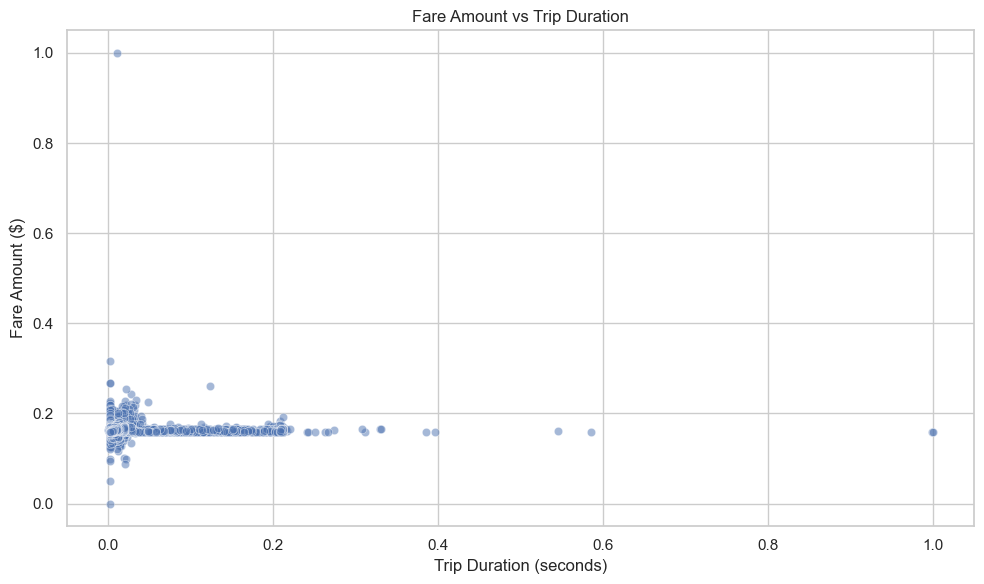

VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  3.588295e+06                     3588295                     3588295   
mean   1.713103e+00  2022-05-16 07:50:29.219312  2022-05-16 08:08:42.275203   
min    1.000000e+00         2003-01-01 00:06:06         2003-01-01 00:31:38   
25%    1.000000e+00  2022-05-08 18:14:16.500000         2022-05-08 18:32:36   
50%    2.000000e+00         2022-05-16 09:14:42         2022-05-16 09:33:15   
75%    2.000000e+00         2022-05-23 18:03:17  2022-05-23 18:21:03.500000   
max    6.000000e+00         2022-06-01 23:55:30         2022-06-02 00:03:51   
std    4.888093e-01                         NaN                         NaN   

       passenger_count  trip_distance    RatecodeID  PULocationID  \
count     3.458771e+06   3.588295e+06  3.458771e+06  3.588295e+06   
mean      1.393923e+00   6.856861e+00  1.365674e+00  1.645738e+02   
min       0.000000e+00   0.000000e+00  1.000000e+00  1.000000e+00   
25%       1.000000e+00   1.150000e+00  1.000000e+00  1.320000e+02   
50%       1.000000e+00   1.960000e+00  1.000000e+00  1.620000e+02   
75%       1.000000e+00   3.730000e+00  1.000000e+00  2.340000e+02   
max       9.000000e+00   3.571927e+05  9.900000e+01  2.650000e+02   
std       9.555489e-01   6.908488e+02  5.239789e+00  6.562813e+01   

       DOLocationID  payment_type   fare_amount  ...  tolls_amount  \
count  3.588295e+06  3.588295e+06  3.588295e+06  ...  3.588295e+06   
mean   1.625517e+02  1.183209e+00  1.516813e+01  ...  5.827756e-01   
min    1.000000e+00  0.000000e+00 -1.311500e+03  ... -5.075000e+01   
25%    1.130000e+02  1.000000e+00  7.000000e+00  ...  0.000000e+00   
50%    1.620000e+02  1.000000e+00  1.050000e+01  ...  0.000000e+00   
75%    2.340000e+02  1.000000e+00  1.700000e+01  ...  0.000000e+00   
max    2.650000e+02  4.000000e+00  6.966500e+03  ...  8.137500e+02   
std    7.027926e+01  5.075988e-01  1.489484e+01  ...  2.173699e+00   

       improvement_surcharge  total_amount  congestion_surcharge  \
count           3.588295e+06  3.588295e+06          3.458771e+06   
mean            2.964299e-01  2.207840e+01          2.282808e+00   
min            -3.000000e-01 -1.314800e+03         -2.500000e+00   
25%             3.000000e-01  1.235000e+01          2.500000e+00   
50%             3.000000e-01  1.630000e+01          2.500000e+00   
75%             3.000000e-01  2.376000e+01          2.500000e+00   
max             3.000000e-01  6.970800e+03          2.750000e+00   
std             4.576907e-02  1.848683e+01          7.452415e-01   

        airport_fee           trip_duration  trip_time_seconds   pickup_hour  \
count  3.458771e+06                 3588295       3.588295e+06  3.588295e+06   
mean   1.008364e-01  0 days 00:18:13.055892       1.093056e+03  1.416653e+01   
min   -1.250000e+00       -1 days +23:45:55      -8.450000e+02  0.000000e+00   
25%    0.000000e+00         0 days 00:07:40       4.600000e+02  1.000000e+01   
50%    0.000000e+00         0 days 00:12:42       7.620000e+02  1.500000e+01   
75%    0.000000e+00         0 days 00:20:37       1.237000e+03  1.900000e+01   
max    1.250000e+00         4 days 17:43:33       4.094130e+05  2.300000e+01   
std    3.434480e-01  0 days 00:51:33.997500       3.093998e+03  5.779488e+00   

      pickup_dayofweek    is_weekend  
count     3.588295e+06  3.588295e+06  
mean      2.918017e+00  2.704764e-01  
min       0.000000e+00  0.000000e+00  
25%       1.000000e+00  0.000000e+00  
50%       3.000000e+00  0.000000e+00  
75%       5.000000e+00  1.000000e+00  
max       6.000000e+00  1.000000e+00  
std       2.000686e+00  4.442060e-01  

[8 rows x 23 columns]

In [8]:
df_raw = TripDurationAdder().fit_transform(df_raw)
df_raw = PickupTimeFeatures().fit_transform(df_raw)
plot_fare_vs_duration(df_raw)
df_raw.describe()

There are some records before May 2022, so they will be removed.

In [10]:
df_raw = df_raw[df_raw["tpep_dropoff_datetime"] >= pd.Timestamp("2022-05-01 00:00:00")]

Since negative fares and durations are not valid for a taxi trip, we will later remove those rows by cleaning and prepocessing the data.
This step ensures the model is not influenced by erroneous entries.

#### Analyze Pick-up/Drop-off Location IDs by Tertiles
##### Tertile Thresholds, Top 5 and Bottom 5 by Trip Count
To understand the spatial patterns of taxi activity in NYC, we analyze the frequency of trips per zone and categorize zones into tertiles based on trip volume.

This gives insight into how busy different areas are and allows understand how desbalanced is the data on terms of location importance.

We compute the number of trips per zone (PULocationID and DOLocationID) and divide them into tertiles:

T1: Low trip activity

T2: Medium trip activity

T3: High trip activity

We display thresholds and the top/bottom 5 zones to better understand zone popularity.

In [11]:
tertiles_by_column = assign_tertiles(df_raw, df_zone)

divission_by_pickupID = tertiles_by_column["PULocationID"]
divission_by_dropoffID = tertiles_by_column["DOLocationID"]


=== 📌 PULocationID Summary ===
• Tertile thresholds:


Thresholds
0.333333          79
0.666667         753

• Top 5 zones by trip count:


LocationID  Top 5 Trip Count    Borough                   Zone service_zone
0         132            175942     Queens            JFK Airport     Airports
1         237            173546  Manhattan  Upper East Side South  Yellow Zone
2         236            152419  Manhattan  Upper East Side North  Yellow Zone
3         161            138543  Manhattan         Midtown Center  Yellow Zone
4         142            120347  Manhattan    Lincoln Square East  Yellow Zone

• Bottom 5 zones by trip count:


LocationID  Bottom 5 Trip Count        Borough  \
0         187                    1  Staten Island   
1          84                    1  Staten Island   
2         105                    1      Manhattan   
3         221                    1  Staten Island   
4         199                    1          Bronx   

                                            Zone service_zone  
0                                  Port Richmond    Boro Zone  
1              Eltingville/Annadale/Prince's Bay    Boro Zone  
2  Governor's Island/Ellis Island/Liberty Island  Yellow Zone  
3                                      Stapleton    Boro Zone  
4                                  Rikers Island    Boro Zone


=== 📌 DOLocationID Summary ===
• Tertile thresholds:


Thresholds
0.333333         533
0.666667        3696

• Top 5 zones by trip count:


LocationID  Top 5 Trip Count    Borough                       Zone  \
0         236            155642  Manhattan      Upper East Side North   
1         237            150512  Manhattan      Upper East Side South   
2         161            130892  Manhattan             Midtown Center   
3         230            106293  Manhattan  Times Sq/Theatre District   
4         170            102740  Manhattan                Murray Hill   

  service_zone  
0  Yellow Zone  
1  Yellow Zone  
2  Yellow Zone  
3  Yellow Zone  
4  Yellow Zone

• Bottom 5 zones by trip count:


LocationID  Bottom 5 Trip Count        Borough  \
0          30                   19         Queens   
1          84                   18  Staten Island   
2           2                    5         Queens   
3         105                    3      Manhattan   
4          99                    2  Staten Island   

                                            Zone service_zone  
0                                  Broad Channel    Boro Zone  
1              Eltingville/Annadale/Prince's Bay    Boro Zone  
2                                    Jamaica Bay    Boro Zone  
3  Governor's Island/Ellis Island/Liberty Island  Yellow Zone  
4                                Freshkills Park    Boro Zone

##### Visualize Trip Counts per Tertile and LocationIDs
We use bar plots to compare trip counts across tertiles, separated by pick-up and drop-off zones.

This helps visually confirm the distribution of zone activity and assess whether the tertile split is informative.


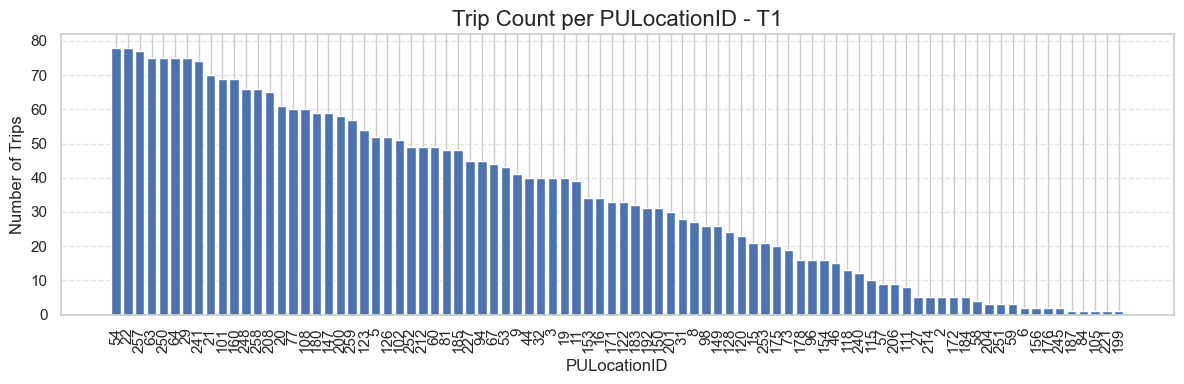

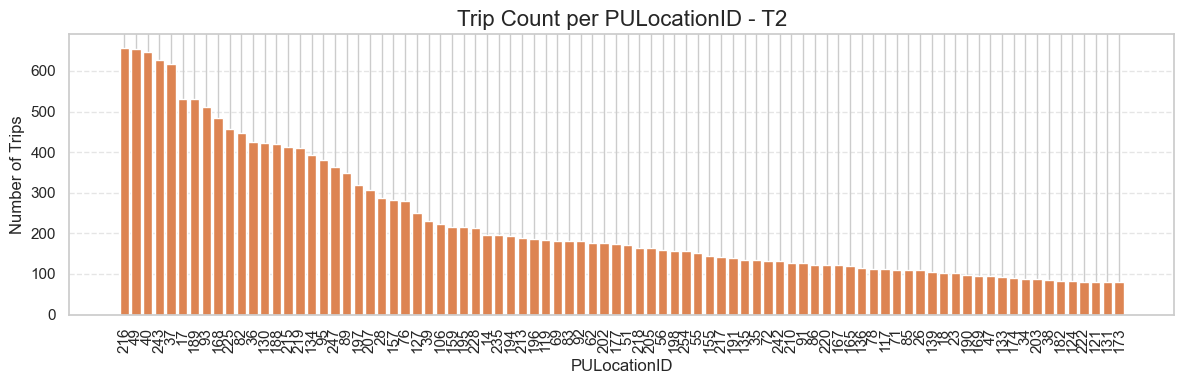

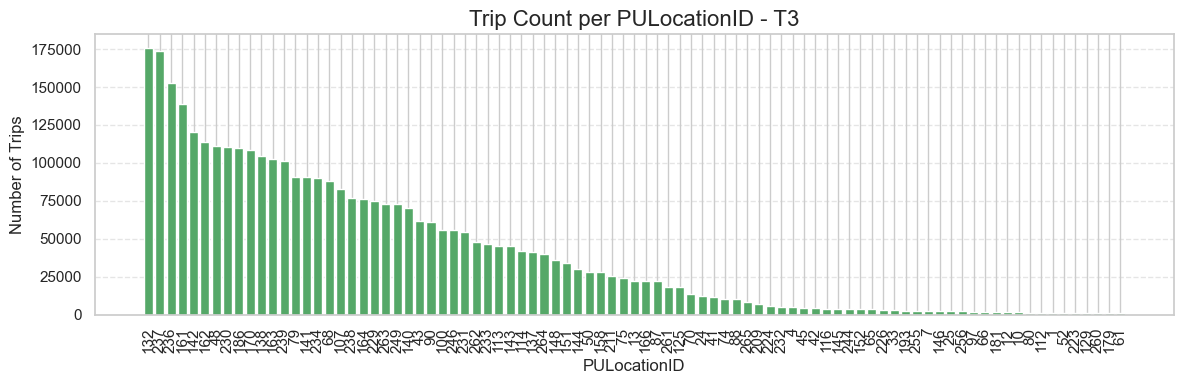

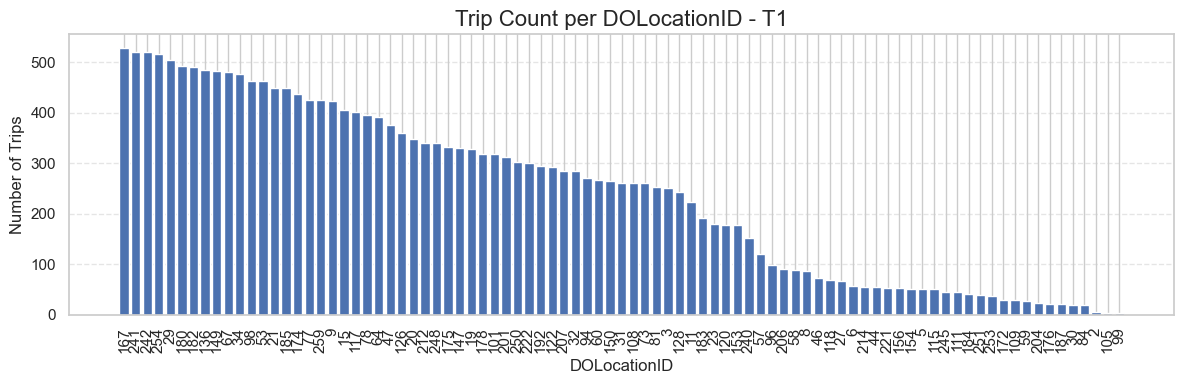

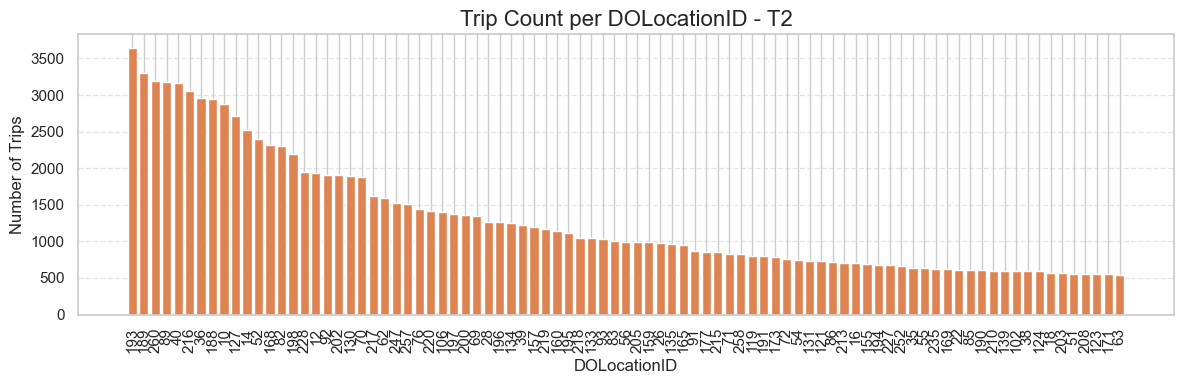

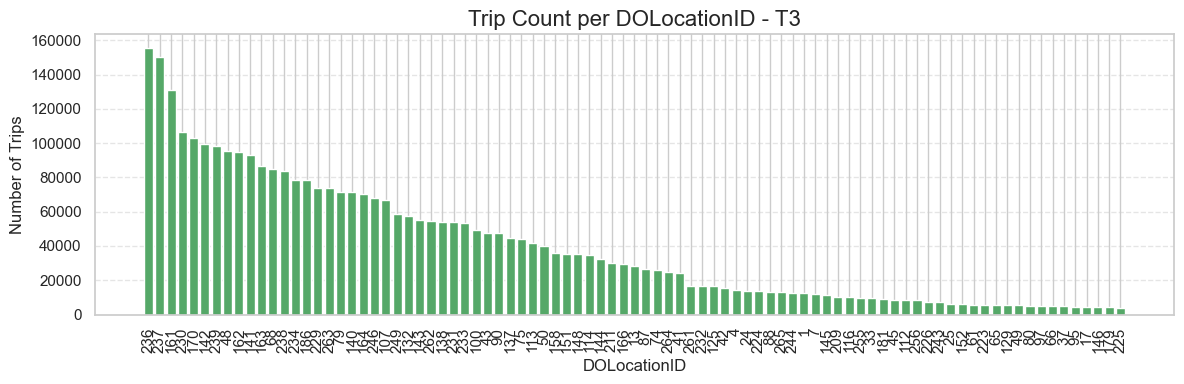

In [12]:
# Visualize as barplots by tertile
plot_trip_counts_by_tertile(
    divission_by_pickupID, ID_column="PULocationID"
)
plot_trip_counts_by_tertile(
    divission_by_dropoffID, ID_column="DOLocationID"
)

##### Plot Geospatial Data with Tertiles
NYC taxi zones are visualized on a map, with each zone color-coded by its tertile.

This geospatial representation allows us to see the spatial distribution of trip intensity, including hotspots like airports and Manhattan.

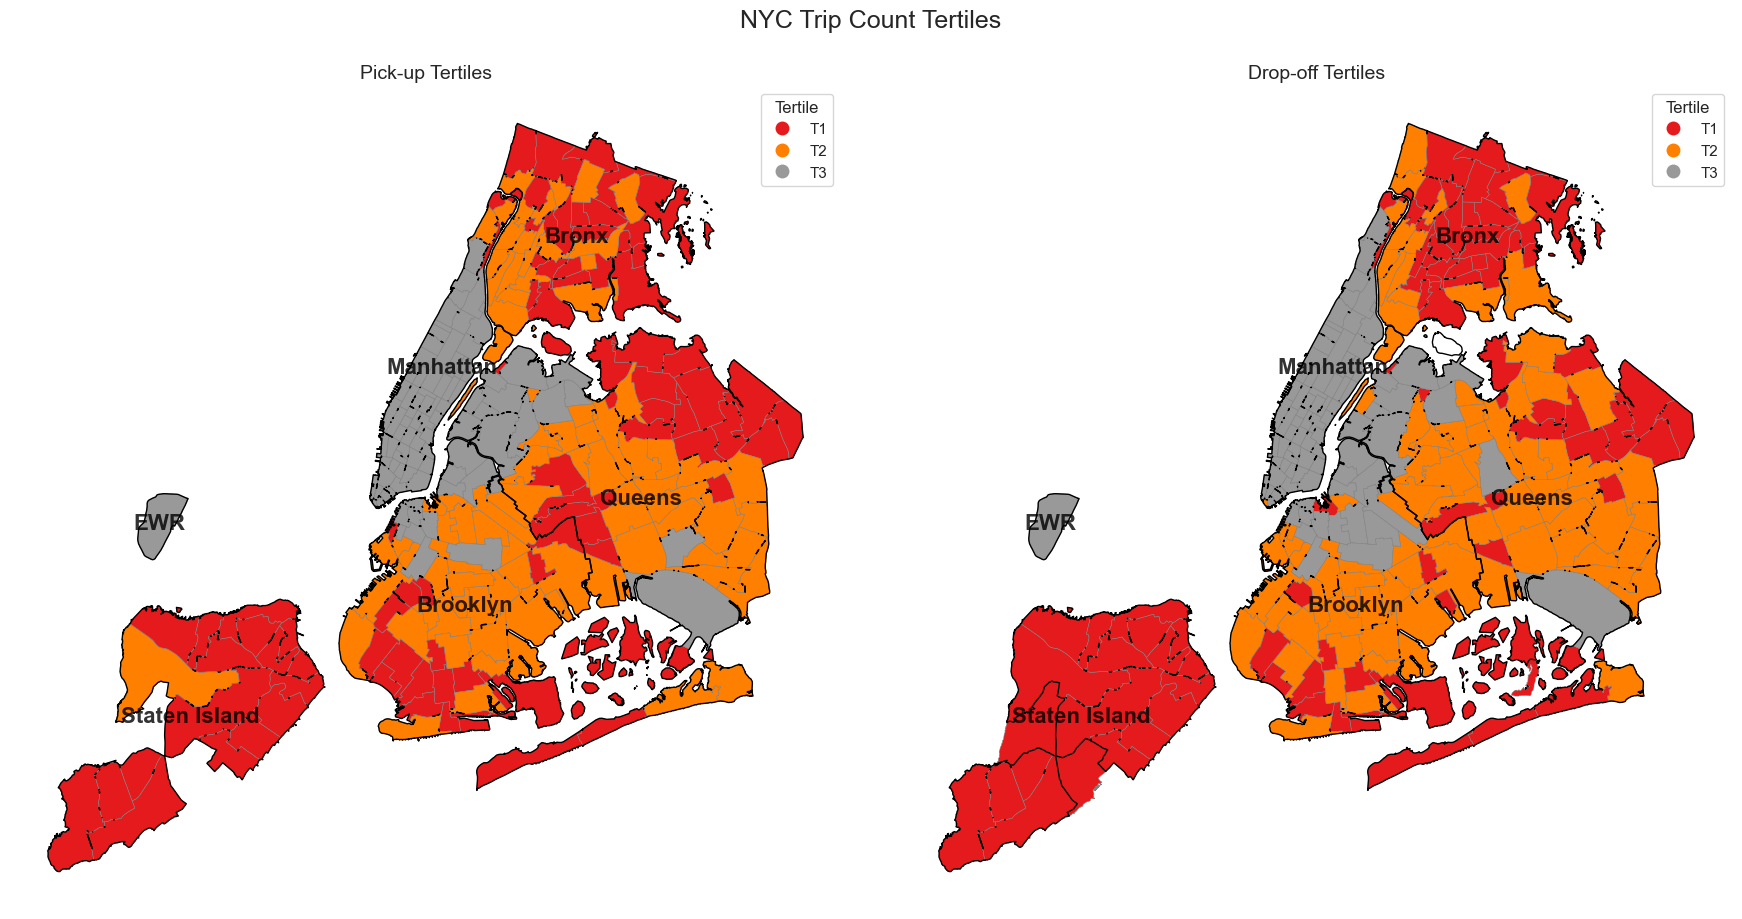

In [13]:
# Load taxi zones (NYC shapefile from project config)
zones_gdf = read_taxi_zones_dataset_from_shapefile()

# Merge with tertile and borough info
zones_gdf["LocationID"] = zones_gdf["LocationID"].astype(int)
# Plot geospatial data with tertiles
plot_geospatial_data(zones_gdf, divission_by_pickupID, divission_by_dropoffID)


##### Plot the NYC Zones with Tertiles and Location IDs
A complementary map displays each zone with its LocationID and tertile. An accompanying table shows the top 10 zones per tertile.

This map serves as both a spatial reference and a lookup tool, helping in later interpretation of model results involving location IDs.

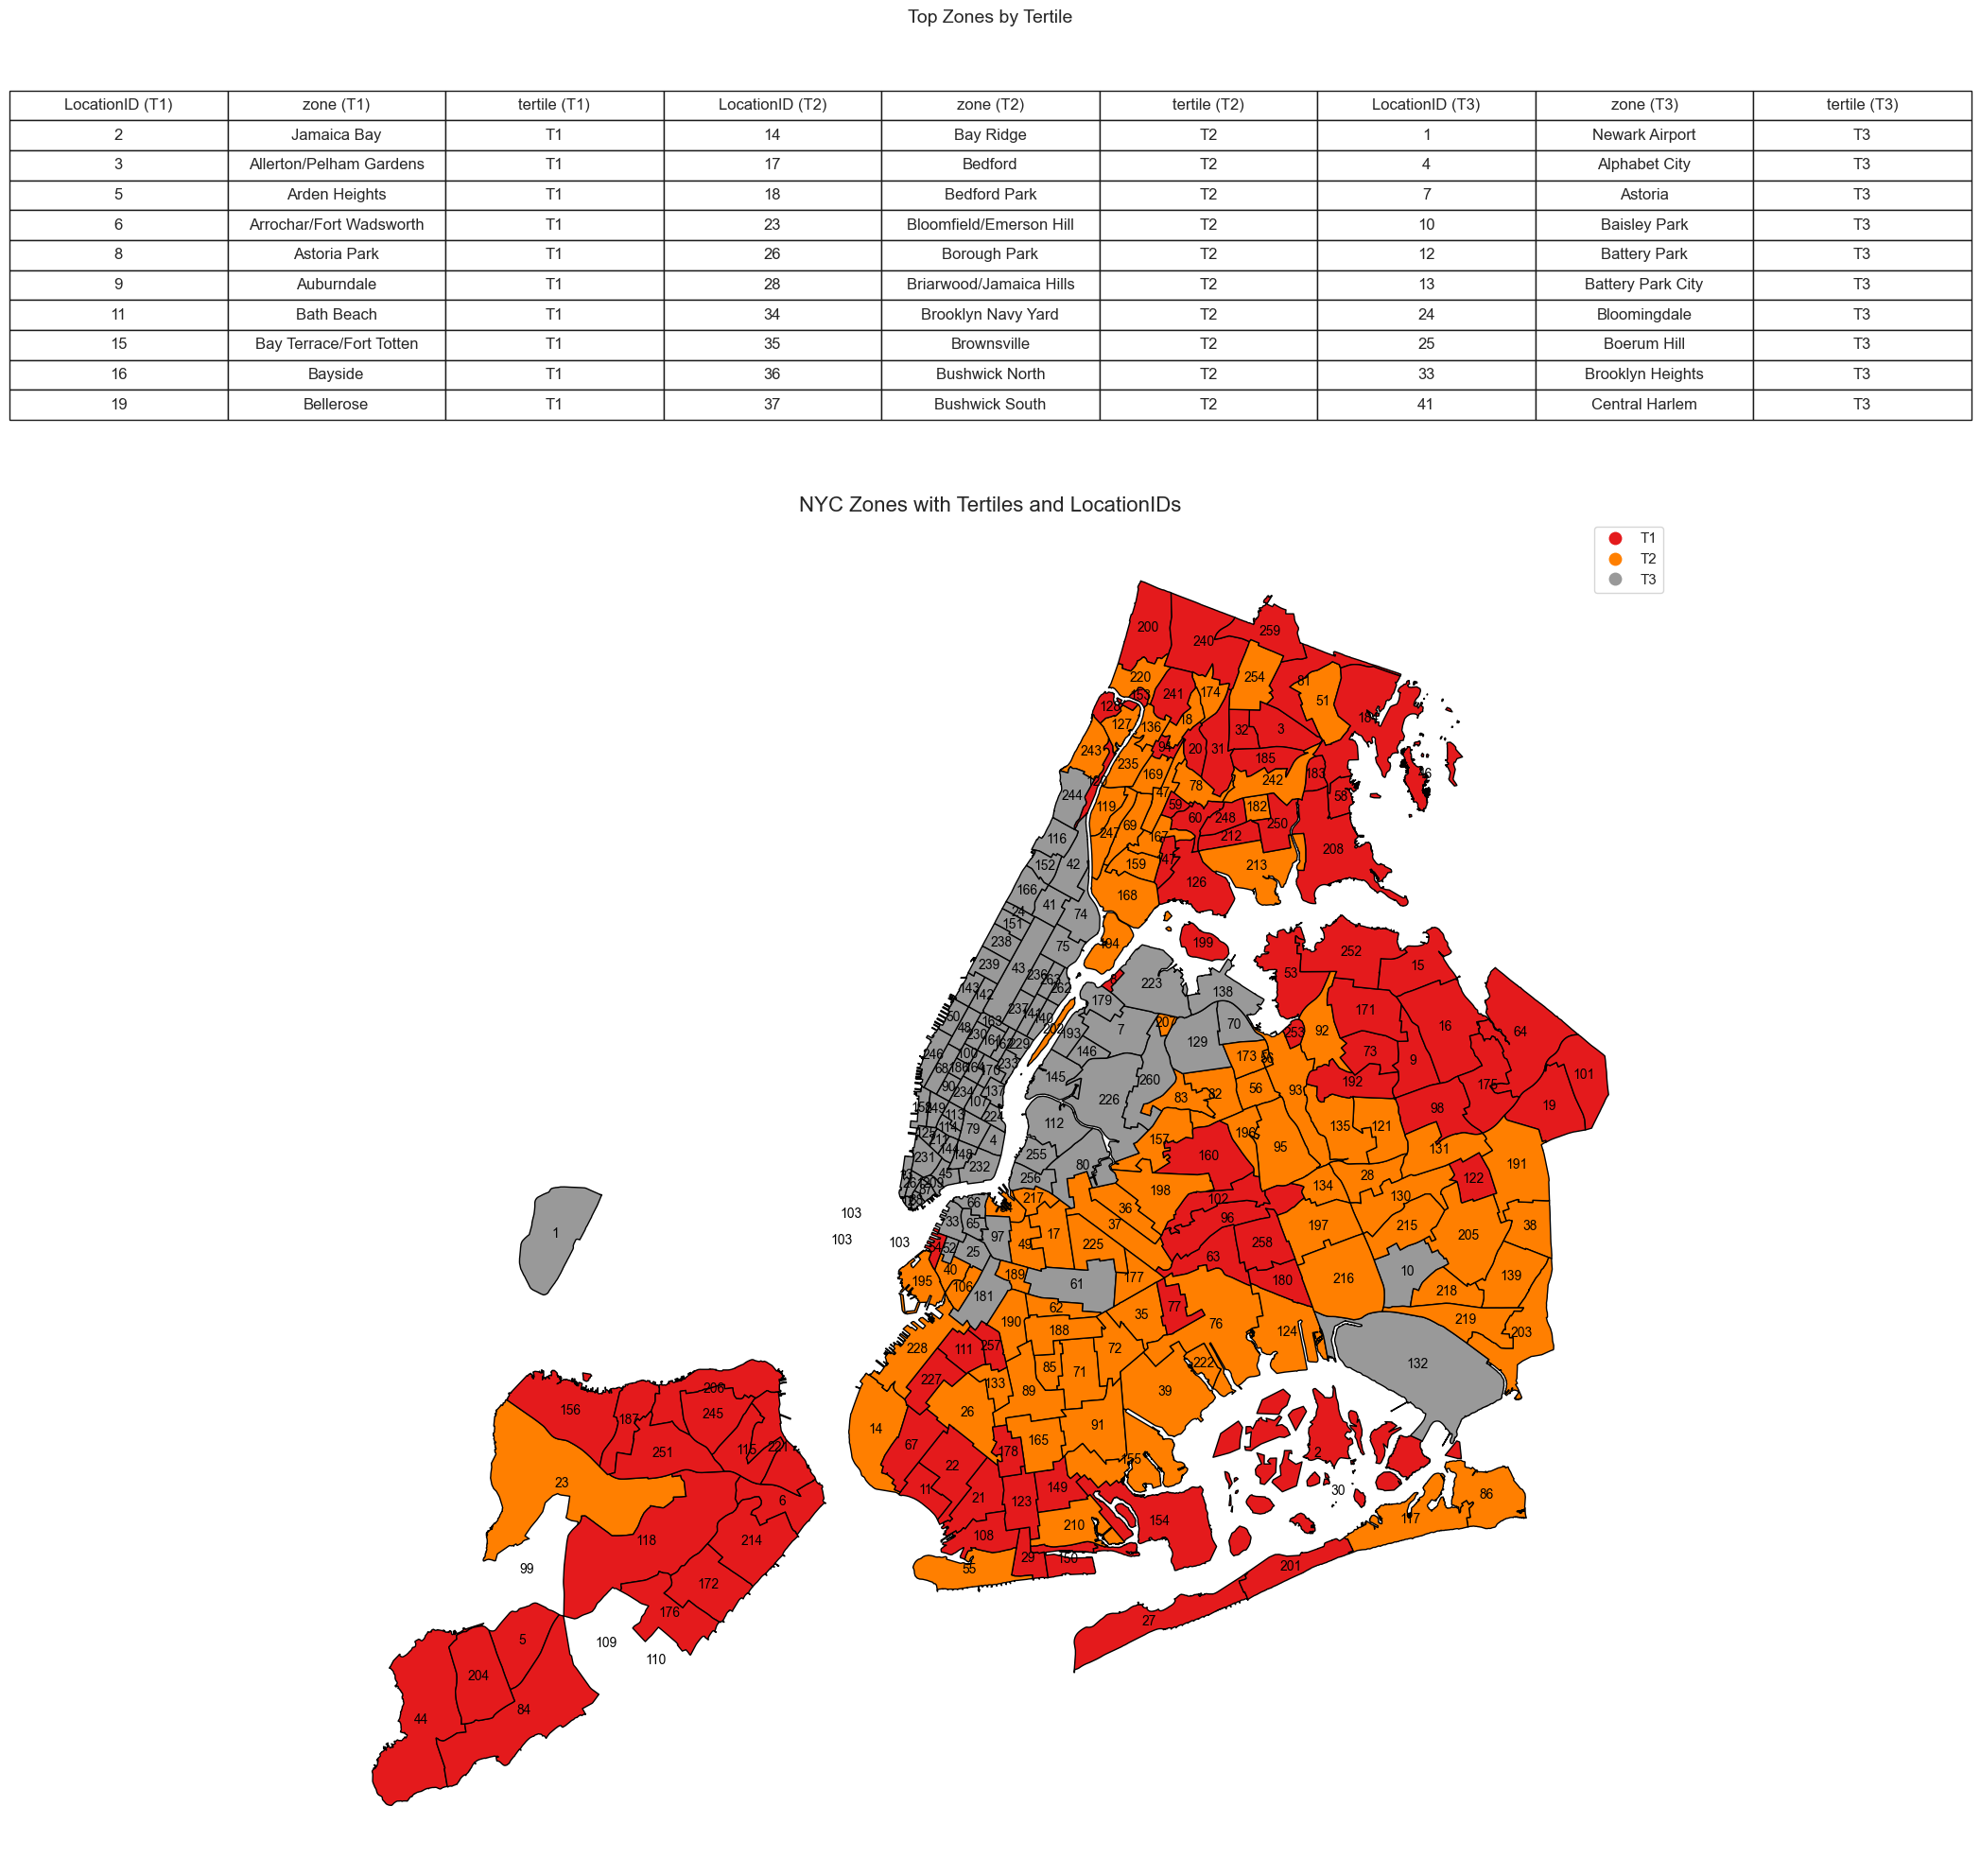

In [14]:
# Merge zones with tertiles and borough information
plot_df = zones_gdf.merge(
    divission_by_pickupID[["LocationID", "tertile", "Borough"]],
    on="LocationID",
    how="left",
)
# Plot the NYC zones with tertiles and location IDs
plot_nyc_zones_with_tertiles_and_location_ids(
    plot_df, show_table=True, table_rows=10
)

### 3. Transform
#### Run the Pipeline to Clean the Data
We apply a custom preprocessing pipeline to clean the dataset, handling missing values, outliers, and feature engineering (e.g., trip duration, pickup hour).

This prepares the data for training a predictive model by ensuring consistent, scaled, and transformed inputs.

In [ ]:
# Run the preprocessing pipeline
df_clean = run_pipeline_chunks(df_raw, chunk_size=50_000)

Processing data in chunks of size 50000...
[✗] Error in chunk 3500000-3550000: Shape of passed values is (50000, 18), indices imply (50000, 22)
[✗] Error in chunk 3550000-3600000: Shape of passed values is (38254, 18), indices imply (38254, 22)

[✓] Processed 3288938 rows successfully.
Final df_clean shape: (3288938, 24)


##### See basics on the cleaned dataset
A quick inspection of the cleaned dataset lets us confirm its structure, types, and whether transformations were applied as expected.

This includes checking the number of features, transformed columns, and date/time preservation.

In [16]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3288938 entries, 0 to 3500040
Data columns (total 24 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   store_and_fwd_flag_Y   float64       
 1   VendorID               float64       
 2   passenger_count        float64       
 3   trip_distance          float64       
 4   RatecodeID             float64       
 5   payment_type           float64       
 6   extra                  float64       
 7   mta_tax                float64       
 8   tip_amount             float64       
 9   tolls_amount           float64       
 10  improvement_surcharge  float64       
 11  total_amount           float64       
 12  congestion_surcharge   float64       
 13  airport_fee            float64       
 14  pickup_hour            float64       
 15  pickup_dayofweek       float64       
 16  is_weekend             float64       
 17  fare_amount            float64       
 18  trip_time_seconds      floa

In [17]:
df_clean.head()

store_and_fwd_flag_Y  VendorID  passenger_count  trip_distance  RatecodeID  \
0                   0.0   -1.5262          -0.4437         0.0901     -0.0566   
1                   0.0   -1.5262          -0.4437        -0.3350     -0.0566   
2                   0.0   -1.5262          -0.4437         0.1137     -0.0566   
4                   0.0   -1.5262          -0.4437        -0.5003     -0.0566   
5                   0.0    0.6552          -0.4437        -0.4365     -0.0566   

   payment_type   extra  mta_tax  tip_amount  tolls_amount  ...  pickup_hour  \
0        1.8219  1.8263   0.0274     -0.8600       -0.3029  ...      -1.5964   
1        1.8219  1.8263   0.0274     -0.8600       -0.3029  ...      -1.5964   
2        1.8219  1.8263   0.0274     -0.8600       -0.3029  ...      -1.5964   
4       -0.5069  1.8263   0.0274     -0.1263       -0.3029  ...      -1.5964   
5       -0.5069 -0.3229   0.0274      0.0074       -0.3029  ...       2.9091   

   pickup_dayofweek  is_weekend  fare_amount  trip_time_seconds  \
0            0.0322      0.0131         17.0             1122.0   
1            0.0322      0.0131         11.0              829.0   
2            0.0322      0.0131         15.5              922.0   
4            0.0322      0.0131          7.5              563.0   
5          -12.9778      0.0131          9.5              690.0   

   tpep_pickup_datetime  tpep_dropoff_datetime  trip_duration  PULocationID  \
0   2022-05-01 00:00:36    2022-05-01 00:19:18         1122.0           246   
1   2022-05-01 00:27:44    2022-05-01 00:41:33          829.0           238   
2   2022-05-01 00:59:00    2022-05-01 01:14:22          922.0           163   
4   2022-05-01 00:28:26    2022-05-01 00:37:49          563.0           238   
5   2022-04-30 23:53:47    2022-05-01 00:05:17          690.0           249   

  DOLocationID  
0          151  
1           74  
2          260  
4           75  
5          164  

[5 rows x 24 columns]

In [18]:
# Save the cleaned data to a Parquet file
df_clean.to_parquet("datasets/cleaned_trip_data.parquet")

#### Analyze Targets and Outliers on Cleaned Data
We revisit target variables (fare_amount, trip_duration) after cleaning to ensure that the distributions remain meaningful.

This helps validate that the cleaning pipeline preserved the core structure of the prediction targets.

In [19]:
df_raw_cleaned = df_raw.loc[df_clean.index].copy()
# Check target distributions
print("Statistics after cleaning:")
df_raw_cleaned.describe()

Statistics after cleaning:


VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  3.288938e+06                     3288938                     3288938   
mean   1.698194e+00  2022-05-16 06:19:24.936608  2022-05-16 06:34:41.583068   
min    1.000000e+00         2022-04-30 23:40:23         2022-05-01 00:00:50   
25%    1.000000e+00         2022-05-08 15:08:40         2022-05-08 15:24:15   
50%    2.000000e+00  2022-05-16 04:57:39.500000  2022-05-16 05:13:56.500000   
75%    2.000000e+00  2022-05-23 17:34:45.750000  2022-05-23 17:51:12.500000   
max    6.000000e+00         2022-06-01 23:55:30         2022-06-02 00:02:50   
std    4.623522e-01                         NaN                         NaN   

       passenger_count  trip_distance    RatecodeID  PULocationID  \
count     3.254608e+06   3.288938e+06  3.254608e+06  3.288938e+06   
mean      1.393183e+00   3.785680e+00  1.180453e+00  1.654925e+02   
min       0.000000e+00   0.000000e+00  1.000000e+00  1.000000e+00   
25%       1.000000e+00   1.130000e+00  1.000000e+00  1.320000e+02   
50%       1.000000e+00   1.890000e+00  1.000000e+00  1.620000e+02   
75%       1.000000e+00   3.340000e+00  1.000000e+00  2.340000e+02   
max       6.000000e+00   3.336330e+05  9.900000e+01  2.650000e+02   
std       9.566306e-01   2.854232e+02  3.677806e+00  6.549372e+01   

       DOLocationID  payment_type   fare_amount  ...  tolls_amount  \
count  3.288938e+06  3.288938e+06  3.288938e+06  ...  3.288938e+06   
mean   1.639230e+02  1.195819e+00  1.344675e+01  ...  4.441226e-01   
min    1.000000e+00  0.000000e+00  2.000000e+00  ...  0.000000e+00   
25%    1.140000e+02  1.000000e+00  7.000000e+00  ...  0.000000e+00   
50%    1.620000e+02  1.000000e+00  1.000000e+01  ...  0.000000e+00   
75%    2.340000e+02  1.000000e+00  1.550000e+01  ...  0.000000e+00   
max    2.650000e+02  4.000000e+00  6.720000e+01  ...  8.137500e+02   
std    6.924228e+01  4.351411e-01  1.048145e+01  ...  1.719721e+00   

       improvement_surcharge  total_amount  congestion_surcharge  \
count           3.288938e+06  3.288938e+06          3.254608e+06   
mean            2.999933e-01  2.009794e+01          2.372166e+00   
min             0.000000e+00  2.300000e+00          0.000000e+00   
25%             3.000000e-01  1.230000e+01          2.500000e+00   
50%             3.000000e-01  1.580000e+01          2.500000e+00   
75%             3.000000e-01  2.180000e+01          2.500000e+00   
max             3.000000e-01  8.455500e+02          2.750000e+00   
std             1.413351e-03  1.383595e+01          5.506756e-01   

        airport_fee           trip_duration  trip_time_seconds   pickup_hour  \
count  3.254608e+06                 3288938       3.288938e+06  3.288938e+06   
mean   7.987175e-02  0 days 00:15:16.646459       9.166465e+02  1.422045e+01   
min    0.000000e+00         0 days 00:00:29       2.900000e+01  0.000000e+00   
25%    0.000000e+00         0 days 00:07:36       4.560000e+02  1.100000e+01   
50%    0.000000e+00         0 days 00:12:16       7.360000e+02  1.500000e+01   
75%    0.000000e+00         0 days 00:19:16       1.156000e+03  1.900000e+01   
max    1.250000e+00         0 days 01:50:54       6.654000e+03  2.300000e+01   
std    3.057126e-01  0 days 00:11:39.418247       6.994182e+02  5.749510e+00   

      pickup_dayofweek    is_weekend  
count     3.288938e+06  3.288938e+06  
mean      2.915154e+00  2.701036e-01  
min       0.000000e+00  0.000000e+00  
25%       1.000000e+00  0.000000e+00  
50%       3.000000e+00  0.000000e+00  
75%       5.000000e+00  1.000000e+00  
max       6.000000e+00  1.000000e+00  
std       2.000754e+00  4.440132e-01  

[8 rows x 23 columns]

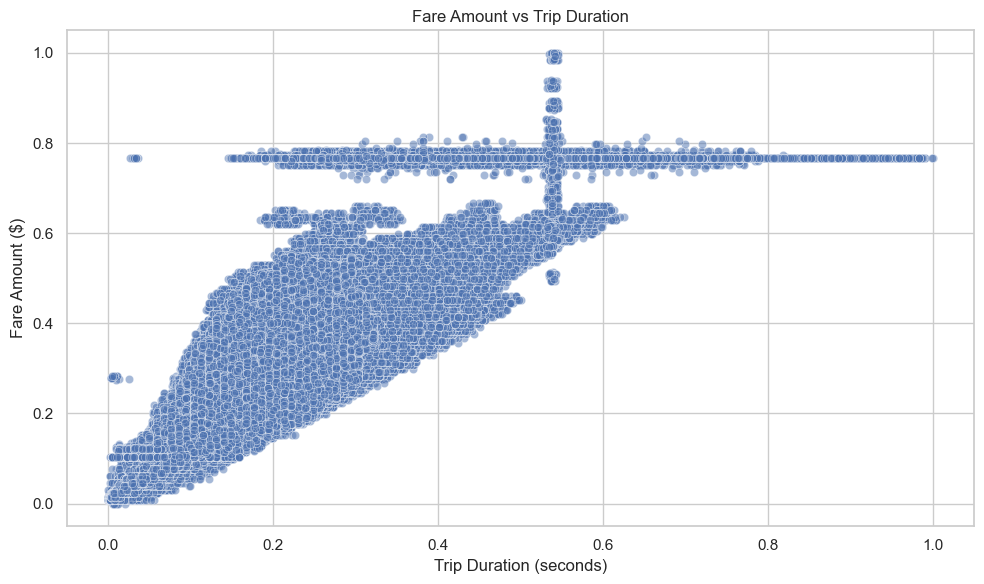

In [20]:
# Visualize fare vs duration
plot_fare_vs_duration(df_raw_cleaned)

#### Refill Rare Zones Based on Similar Months
Some zones may have been dropped due to rare occurrences in the sampled dataset. To maintain location diversity, we refill rare zone samples by sampling similar records from other months.

In [ ]:
# Refill Rare Zones Using Statistically Similar Months

# Identify low-frequency pickup zones
rare_ids = get_location_ids_with_few_records(df_raw_cleaned, threshold=70)

# Automatically select similar months to May using hypothesis testing
similar_months = get_similar_months(
    path_prefix="../data/trip_records/yellow_tripdata_2022-", reference="05", alpha=0.75
)

print("Selected similar months for refilling:", similar_months)

# Refill rare zones from those months
df_refilled = df_raw.copy()
# df_refilled = pd.DataFrame()
for month in similar_months:
    df_refilled = refill_data_using_other_months_data(
        df_refilled, month=int(month), year=2022, locations_to_analyze=rare_ids
    )


Locations with fewer than 70 records: [218, 190, 62, 35, 135, 198, 14, 167, 254, 34, 133, 91, 210, 71, 72, 26, 165, 173, 47, 18, 155, 169, 191, 121, 241, 55, 182, 54, 203, 136, 208, 250, 139, 257, 85, 258, 147, 174, 222, 212, 21, 124, 60, 131, 160, 67, 248, 9, 102, 126, 29, 20, 94, 101, 117, 22, 86, 64, 259, 77, 185, 153, 180, 53, 123, 108, 3, 200, 38, 63, 192, 32, 19, 8, 81, 227, 16, 252, 171, 183, 23, 122, 149, 128, 73, 1, 175, 120, 96, 98, 150, 201, 253, 178, 11, 240, 57, 31, 15, 154, 46, 111, 2, 115, 172, 58, 214, 184, 105, 44, 206, 245, 118, 27, 199, np.int32(5), np.int32(6), np.int32(30), np.int32(59), np.int32(84), np.int32(99), np.int32(103), np.int32(109), np.int32(110), np.int32(156), np.int32(176), np.int32(187), np.int32(204), np.int32(221), np.int32(251)]

count_trips_05 vs count_trips_01
  - Mann-Whitney U p-value: 0.1738
  - KS test p-value: 0.5096

count_trips_05 vs count_trips_02
  - Mann-Whitney U p-value: 0.5381
  - KS test p-value: 0.8443

count_trips_05 vs count_tr

In [22]:
df_refilled.shape

(3641726, 24)

##### Compare Borough Distributions Before and After Refilling
We visualize pickup and dropoff distributions by borough before and after refilling to validate that our augmentation introduces a more balanced spatial distribution without distorting the data.

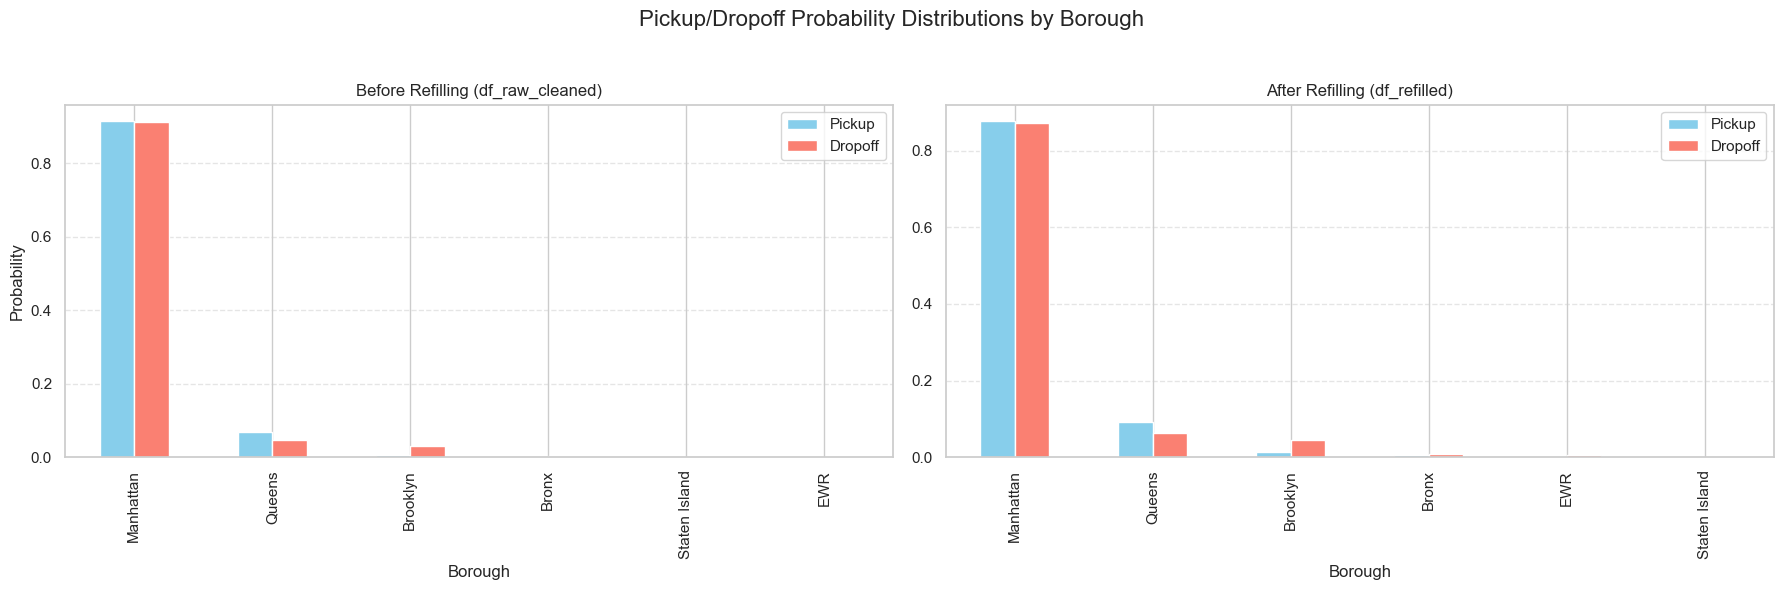

In [23]:
# Compare borough distributions before and after refilling
plot_borough_distribution_comparison(df_raw_cleaned, df_refilled, df_zone)

##### Re-run the Pipeline on the Refilled Dataset
After appending the new samples, we reapply the preprocessing pipeline to clean the augmented dataset and ensure consistency in feature generation.

In [24]:
# Re-run the pipeline on the refilled dataset
df_refilled_clean = run_pipeline_chunks(df_refilled, chunk_size=50_000)

Processing data in chunks of size 50000...
[✗] Error in chunk 3500000-3550000: Shape of passed values is (50000, 18), indices imply (50000, 22)
[✗] Error in chunk 3600000-3650000: Shape of passed values is (41726, 19), indices imply (41726, 22)

[✓] Processed 3328186 rows successfully.
Final df_clean shape: (3328186, 24)


In [25]:
df_refilled_clean.head()

store_and_fwd_flag_Y  VendorID  passenger_count  trip_distance  RatecodeID  \
0                   0.0   -1.5262          -0.4437         0.0901     -0.0566   
1                   0.0   -1.5262          -0.4437        -0.3350     -0.0566   
2                   0.0   -1.5262          -0.4437         0.1137     -0.0566   
4                   0.0   -1.5262          -0.4437        -0.5003     -0.0566   
5                   0.0    0.6552          -0.4437        -0.4365     -0.0566   

   payment_type   extra  mta_tax  tip_amount  tolls_amount  ...  pickup_hour  \
0        1.8219  1.8263   0.0274     -0.8600       -0.3029  ...      -1.5964   
1        1.8219  1.8263   0.0274     -0.8600       -0.3029  ...      -1.5964   
2        1.8219  1.8263   0.0274     -0.8600       -0.3029  ...      -1.5964   
4       -0.5069  1.8263   0.0274     -0.1263       -0.3029  ...      -1.5964   
5       -0.5069 -0.3229   0.0274      0.0074       -0.3029  ...       2.9091   

   pickup_dayofweek  is_weekend  fare_amount  trip_time_seconds  \
0            0.0322      0.0131         17.0             1122.0   
1            0.0322      0.0131         11.0              829.0   
2            0.0322      0.0131         15.5              922.0   
4            0.0322      0.0131          7.5              563.0   
5          -12.9778      0.0131          9.5              690.0   

   tpep_pickup_datetime  tpep_dropoff_datetime  trip_duration  PULocationID  \
0   2022-05-01 00:00:36    2022-05-01 00:19:18         1122.0           246   
1   2022-05-01 00:27:44    2022-05-01 00:41:33          829.0           238   
2   2022-05-01 00:59:00    2022-05-01 01:14:22          922.0           163   
4   2022-05-01 00:28:26    2022-05-01 00:37:49          563.0           238   
5   2022-04-30 23:53:47    2022-05-01 00:05:17          690.0           249   

  DOLocationID  
0          151  
1           74  
2          260  
4           75  
5          164  

[5 rows x 24 columns]

##### Visualize Fare vs Duration After Refilling
We plot the relationship between fare and trip duration using the refilled data to ensure that augmented samples align with the general fare-duration relationship in order to see the outliers on the targets features.

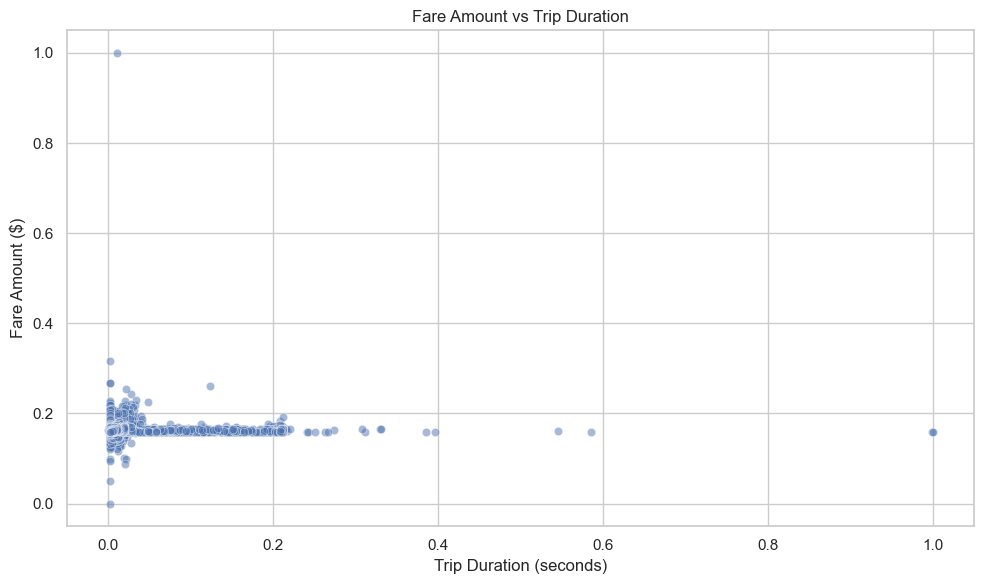

In [26]:
# Visualize fare vs duration after refilling
plot_fare_vs_duration(df_refilled)

Once the cleaned version of the refilled dataset is available, we replot the fare-duration relationship to confirm the transformation preserves realistic patterns.

In [27]:
print("Statistics after refilling and cleaning:")
df_refilled_clean.describe()

Statistics after refilling and cleaning:


store_and_fwd_flag_Y      VendorID  passenger_count  trip_distance  \
count          3.328186e+06  3.328186e+06     3.328186e+06   3.328186e+06   
mean           1.574672e-02  5.315027e-06    -2.886137e-06  -2.942143e-07   
min            0.000000e+00 -1.619500e+00    -5.082700e+00  -9.187000e-01   
25%            0.000000e+00 -1.468500e+00    -4.162000e-01  -5.241000e-01   
50%            0.000000e+00  6.455000e-01    -3.777000e-01  -3.224000e-01   
75%            0.000000e+00  6.685000e-01    -1.759000e-01   1.120000e-02   
max            1.000000e+00  6.793600e+00     2.498380e+01   2.167989e+02   
std            1.244940e-01  1.000002e+00     1.000002e+00   1.000000e+00   

         RatecodeID  payment_type         extra       mta_tax    tip_amount  \
count  3.328186e+06  3.328186e+06  3.328186e+06  3.328186e+06  3.328186e+06   
mean   2.942414e-06 -3.075219e-06 -2.998480e-06 -4.124078e-06  1.606881e-07   
min   -3.995100e+00 -5.795000e-01 -1.239200e+00 -7.244000e+01 -1.409300e+00   
25%   -5.460000e-02 -5.091000e-01 -7.226000e-01  2.010000e-02 -5.964000e-01   
50%   -4.820000e-02 -4.866000e-01 -4.451000e-01  2.530000e-02 -1.519000e-01   
75%   -4.260000e-02 -4.430000e-01  1.112700e+00  2.880000e-02  2.547000e-01   
max    2.001128e+02  8.729600e+00  4.512200e+01  1.540308e+02  1.288126e+02   
std    9.999999e-01  1.000005e+00  1.000004e+00  1.000000e+00  1.000000e+00   

       tolls_amount  ...   pickup_hour  pickup_dayofweek    is_weekend  \
count  3.328186e+06  ...  3.328186e+06      3.328186e+06  3.328186e+06   
mean   3.544574e-07  ... -6.895949e-07     -1.726135e-06  7.098461e-07   
min   -3.308000e-01  ... -1.057010e+01     -1.534585e+02 -1.534585e+02   
25%   -2.827000e-01  ... -7.957000e-01     -1.380000e-02  0.000000e+00   
50%   -2.615000e-01  ...  1.050000e-01      0.000000e+00  0.000000e+00   
75%   -2.362000e-01  ...  8.134000e-01      3.220000e-02  0.000000e+00   
max    1.977776e+02  ...  4.766100e+00      2.173568e+02  2.173568e+02   
std    1.000001e+00  ...  1.000000e+00      8.383297e-01  5.791680e-01   

        fare_amount  trip_time_seconds           tpep_pickup_datetime  \
count  3.328186e+06       3.328186e+06                        3328186   
mean   1.353181e+01       9.202031e+02  2022-05-16 06:19:15.646293760   
min    2.000000e+00       1.700000e+01            2022-03-01 00:45:56   
25%    7.000000e+00       4.580000e+02  2022-05-08 15:45:12.249999872   
50%    1.000000e+01       7.400000e+02            2022-05-16 09:31:56   
75%    1.550000e+01       1.162000e+03  2022-05-23 19:20:16.750000128   
max    1.008000e+02       6.654000e+03            2022-06-01 23:55:30   
std    1.051053e+01       7.000698e+02                            NaN   

               tpep_dropoff_datetime  trip_duration  PULocationID  \
count                        3328186   3.328186e+06  3.328186e+06   
mean   2022-05-16 06:34:35.849422848   9.202031e+02  1.653235e+02   
min              2022-03-01 01:05:04   1.700000e+01  1.000000e+00   
25%       2022-05-08 16:00:48.500000   4.580000e+02  1.320000e+02   
50%              2022-05-16 09:47:29   7.400000e+02  1.620000e+02   
75%    2022-05-23 19:33:15.750000128   1.162000e+03  2.340000e+02   
max              2022-06-02 00:02:50   6.654000e+03  2.650000e+02   
std                              NaN   7.000698e+02  6.566234e+01   

       DOLocationID  
count  3.328186e+06  
mean   1.637506e+02  
min    1.000000e+00  
25%    1.140000e+02  
50%    1.620000e+02  
75%    2.340000e+02  
max    2.650000e+02  
std    6.931189e+01  

[8 rows x 24 columns]

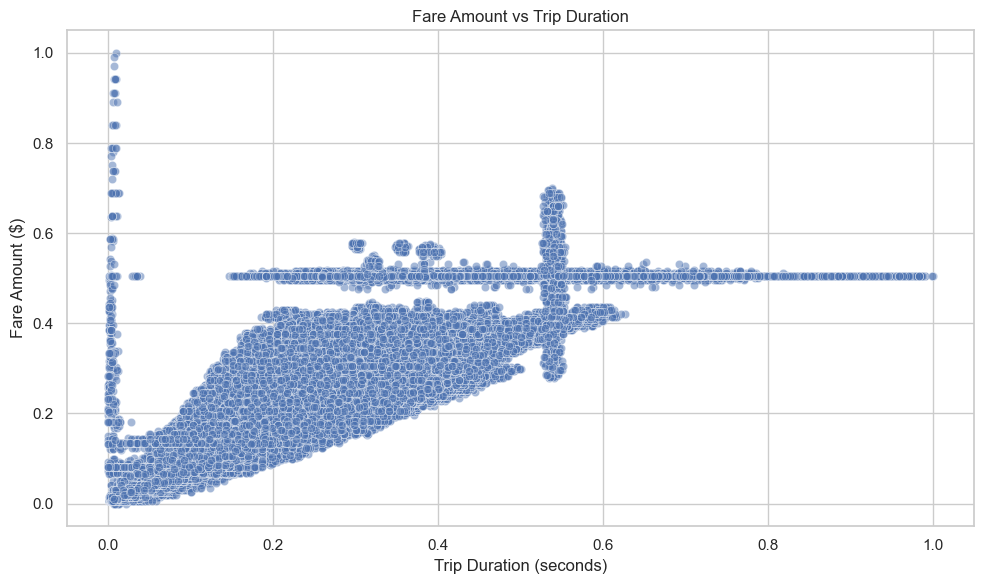

In [28]:
# Visualize fare vs duration after cleaning the refilled data
plot_fare_vs_duration(df_refilled_clean)

#### Compare Borough Distributions — Cleaned Refilled Data
We conclude with another spatial distribution comparison using the final, cleaned refilled dataset to validate the spatial balance post-cleaning.

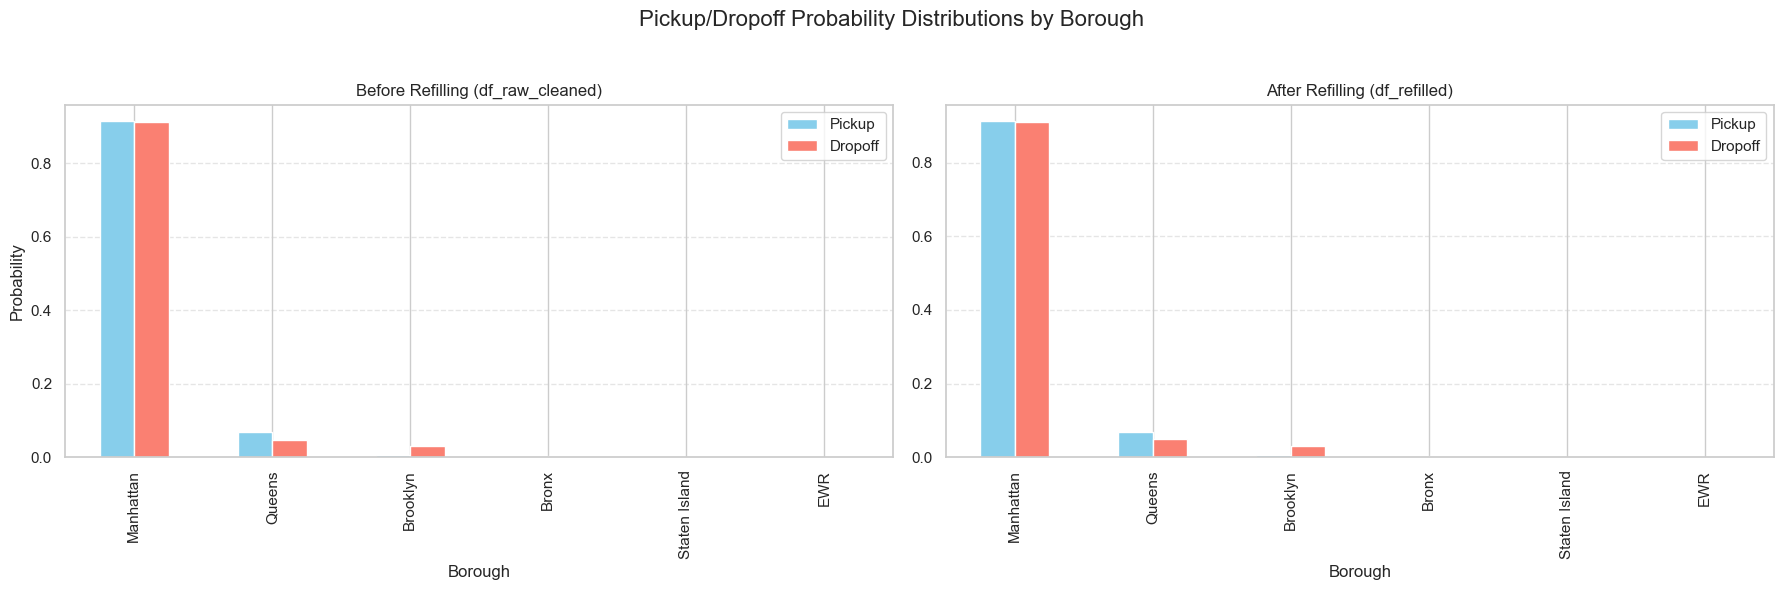

In [29]:
# Compare borough distributions after cleaning the refilled data
plot_borough_distribution_comparison(df_raw_cleaned, df_refilled_clean, df_zone)

In [ ]:
# Save the refilled and cleaned datasets to Parquet files
df_refilled.to_parquet("datasets/refilled_trip_data.parquet")
df_refilled_clean.to_parquet("datasets/refilled_trip_data_cleaned.parquet")

#### Tertile Analysis & Visualization
##### After refilling
We compute trip count tertiles for pickup and dropoff zones in the refilled dataset to assess the distribution of trip density across NYC zones. This helps detect over- or under-represented areas.

In [32]:
# Assign tertiles to the refilled dataset
tertiles_by_column = assign_tertiles(df_refilled, df_zone)

divission_by_pickupID = tertiles_by_column["PULocationID"]
divission_by_dropoffID = tertiles_by_column["DOLocationID"]


=== 📌 PULocationID Summary ===
• Tertile thresholds:


Thresholds
0.333333         361
0.666667        1113

• Top 5 zones by trip count:


LocationID  Top 5 Trip Count    Borough                   Zone service_zone
0         132            175942     Queens            JFK Airport     Airports
1         237            173546  Manhattan  Upper East Side South  Yellow Zone
2         236            152419  Manhattan  Upper East Side North  Yellow Zone
3         161            138543  Manhattan         Midtown Center  Yellow Zone
4         142            120347  Manhattan    Lincoln Square East  Yellow Zone

• Bottom 5 zones by trip count:


LocationID  Bottom 5 Trip Count        Borough  \
0         176                   14  Staten Island   
1          99                   13  Staten Island   
2          84                   11  Staten Island   
3         105                    9      Manhattan   
4         199                    9          Bronx   

                                            Zone service_zone  
0                                        Oakwood    Boro Zone  
1                                Freshkills Park    Boro Zone  
2              Eltingville/Annadale/Prince's Bay    Boro Zone  
3  Governor's Island/Ellis Island/Liberty Island  Yellow Zone  
4                                  Rikers Island    Boro Zone


=== 📌 DOLocationID Summary ===
• Tertile thresholds:


Thresholds
0.333333         709
0.666667        3794

• Top 5 zones by trip count:


LocationID  Top 5 Trip Count    Borough                       Zone  \
0         236            155810  Manhattan      Upper East Side North   
1         237            150688  Manhattan      Upper East Side South   
2         161            131251  Manhattan             Midtown Center   
3         230            106521  Manhattan  Times Sq/Theatre District   
4         170            103206  Manhattan                Murray Hill   

  service_zone  
0  Yellow Zone  
1  Yellow Zone  
2  Yellow Zone  
3  Yellow Zone  
4  Yellow Zone

• Bottom 5 zones by trip count:


LocationID  Bottom 5 Trip Count        Borough  \
0          84                   26  Staten Island   
1         176                   26  Staten Island   
2          99                   10  Staten Island   
3           2                    8         Queens   
4         105                    5      Manhattan   

                                            Zone service_zone  
0              Eltingville/Annadale/Prince's Bay    Boro Zone  
1                                        Oakwood    Boro Zone  
2                                Freshkills Park    Boro Zone  
3                                    Jamaica Bay    Boro Zone  
4  Governor's Island/Ellis Island/Liberty Island  Yellow Zone

##### Visualize Bar Plots by Tertile
We visualize the number of trips per location, grouped by tertile. This helps highlight which zones are most active in each tertile category and supports fairness in spatial sampling.

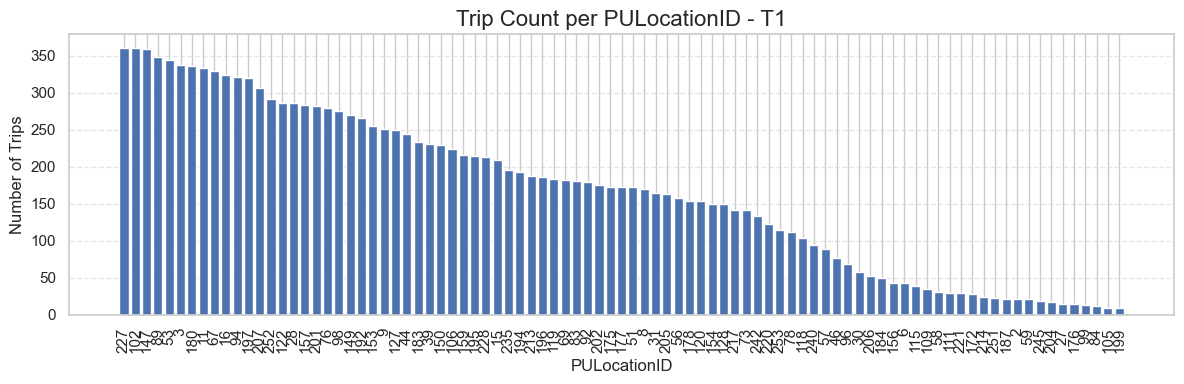

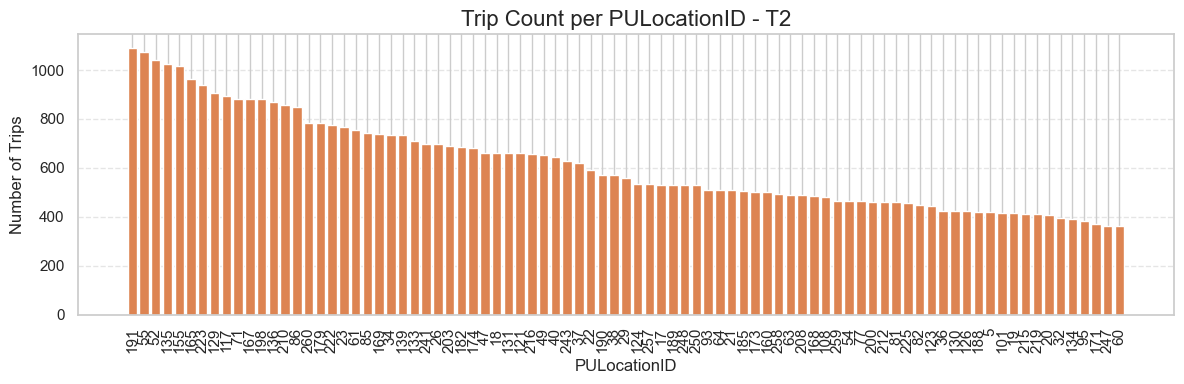

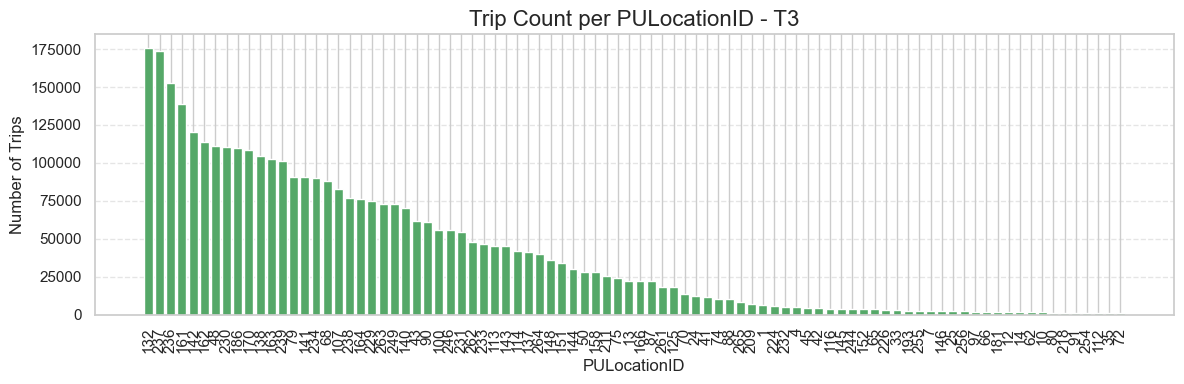

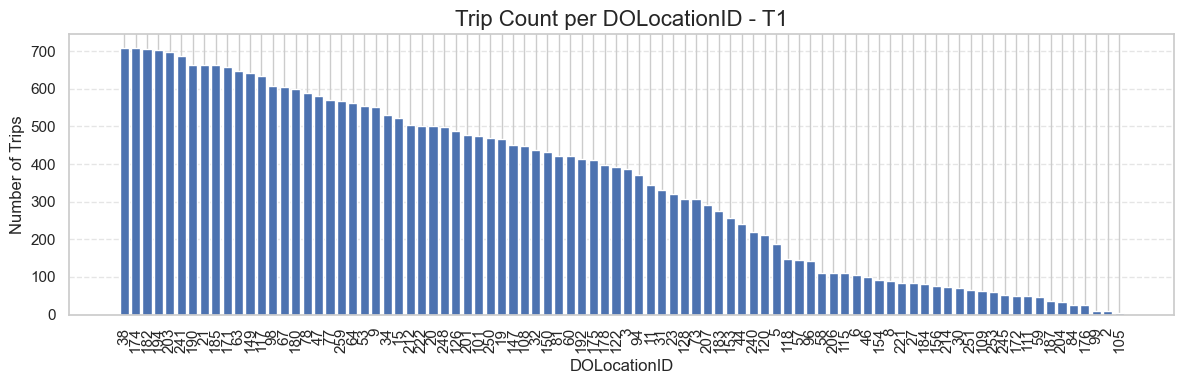

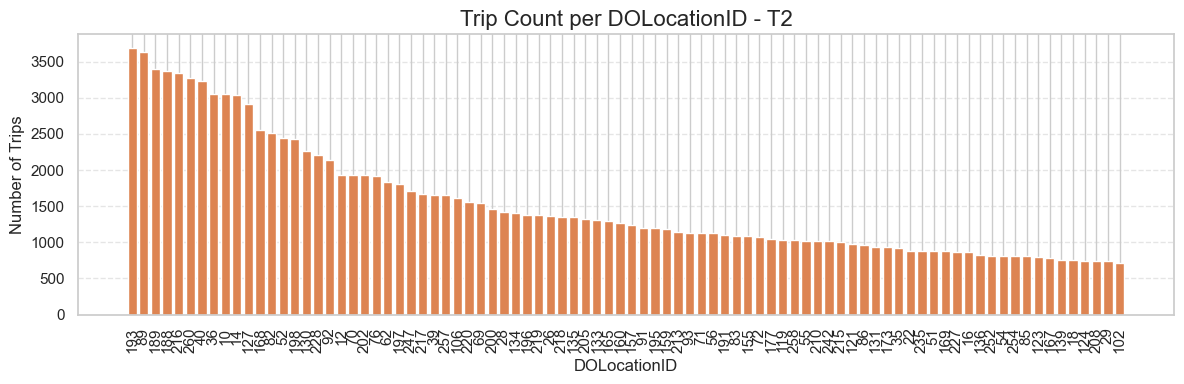

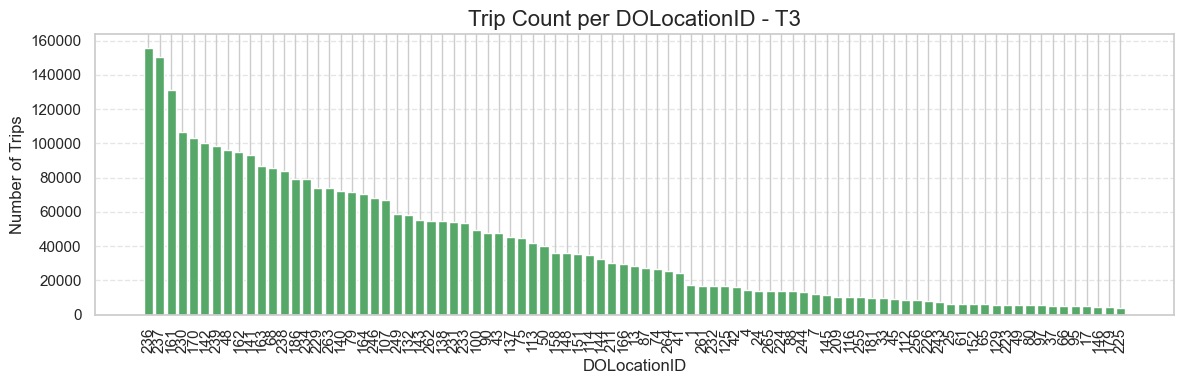

In [33]:
# Visualize as barplots by tertile
plot_trip_counts_by_tertile(divission_by_pickupID, ID_column="PULocationID")
plot_trip_counts_by_tertile(divission_by_dropoffID, ID_column="DOLocationID")

##### Plot Geospatial Data with Tertiles
We map each zone and color-code it by tertile category. This visual validation ensures geographical diversity across high-, medium-, and low-frequency pickup and dropoff zones.

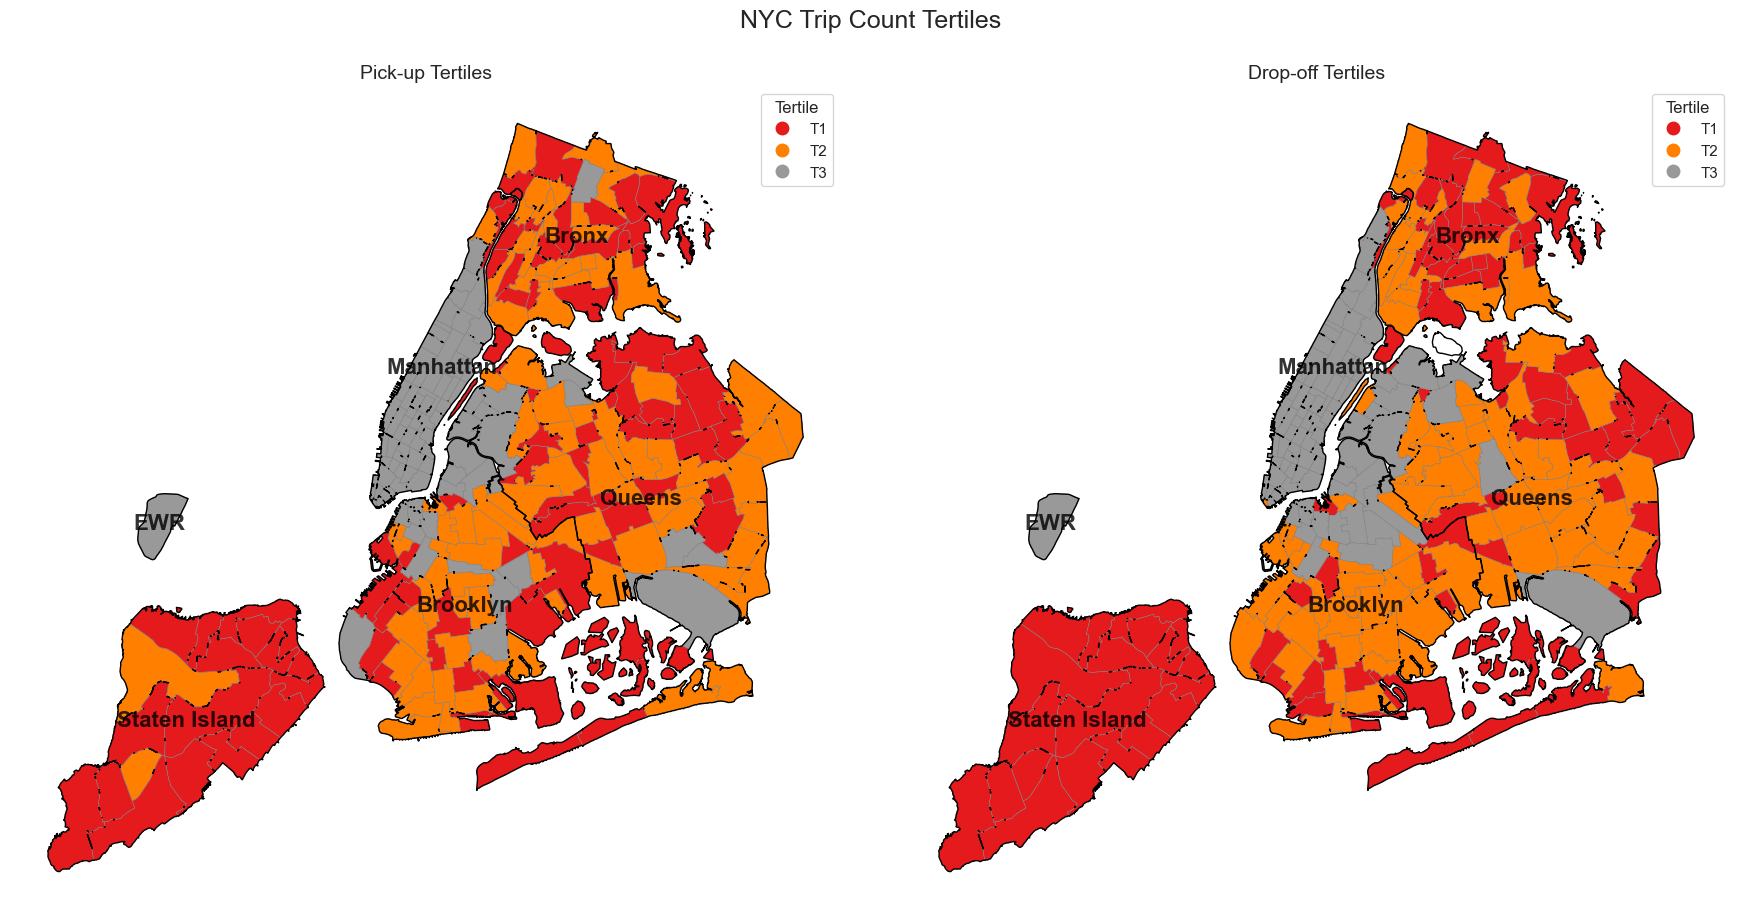

In [34]:
# Load taxi zones (NYC shapefile from project config)
zones_gdf = read_taxi_zones_dataset_from_shapefile()

# Merge with tertile and borough info
zones_gdf["LocationID"] = zones_gdf["LocationID"].astype(int)

# Plot geospatial data with tertiles
plot_geospatial_data(zones_gdf, divission_by_pickupID, divission_by_dropoffID)

#### Tertile Analysis & Visualization
##### After cleaning the refilled data
After cleaning the refilled dataset, we recompute the tertiles. This reveals how data cleaning (e.g., outlier removal) impacts the spatial distribution of trip density.

In [35]:
# Assign tertiles to the refilled dataset
tertiles_by_column = assign_tertiles(df_refilled_clean, df_zone)

divission_by_pickupID = tertiles_by_column["PULocationID"]
divission_by_dropoffID = tertiles_by_column["DOLocationID"]


=== 📌 PULocationID Summary ===
• Tertile thresholds:


Thresholds
0.333333          87
0.666667         478

• Top 5 zones by trip count:


LocationID  Top 5 Trip Count    Borough                   Zone service_zone
0         237            169114  Manhattan  Upper East Side South  Yellow Zone
1         236            148216  Manhattan  Upper East Side North  Yellow Zone
2         161            132802  Manhattan         Midtown Center  Yellow Zone
3         132            125310     Queens            JFK Airport     Airports
4         142            115934  Manhattan    Lincoln Square East  Yellow Zone

• Bottom 5 zones by trip count:


LocationID  Bottom 5 Trip Count        Borough  \
0          27                    1         Queens   
1         187                    1  Staten Island   
2         251                    1  Staten Island   
3          30                    1         Queens   
4         156                    1  Staten Island   

                                  Zone service_zone  
0  Breezy Point/Fort Tilden/Riis Beach    Boro Zone  
1                        Port Richmond    Boro Zone  
2                          Westerleigh    Boro Zone  
3                        Broad Channel    Boro Zone  
4                      Mariners Harbor    Boro Zone


=== 📌 DOLocationID Summary ===
• Tertile thresholds:


Thresholds
0.333333         277
0.666667        2438

• Top 5 zones by trip count:


LocationID  Top 5 Trip Count    Borough                       Zone  \
0         236            151952  Manhattan      Upper East Side North   
1         237            147055  Manhattan      Upper East Side South   
2         161            126272  Manhattan             Midtown Center   
3         230            100218  Manhattan  Times Sq/Theatre District   
4         170             99367  Manhattan                Murray Hill   

  service_zone  
0  Yellow Zone  
1  Yellow Zone  
2  Yellow Zone  
3  Yellow Zone  
4  Yellow Zone

• Bottom 5 zones by trip count:


LocationID  Bottom 5 Trip Count        Borough               Zone  \
0           2                    2         Queens        Jamaica Bay   
1         187                    2  Staten Island      Port Richmond   
2         109                    2  Staten Island        Great Kills   
3         176                    1  Staten Island            Oakwood   
4         204                    1  Staten Island  Rossville/Woodrow   

  service_zone  
0    Boro Zone  
1    Boro Zone  
2    Boro Zone  
3    Boro Zone  
4    Boro Zone

##### Visualize Updated Bar Plots
We replot trip frequency distributions by tertile using the cleaned refilled data to confirm whether the balance among zones is preserved.

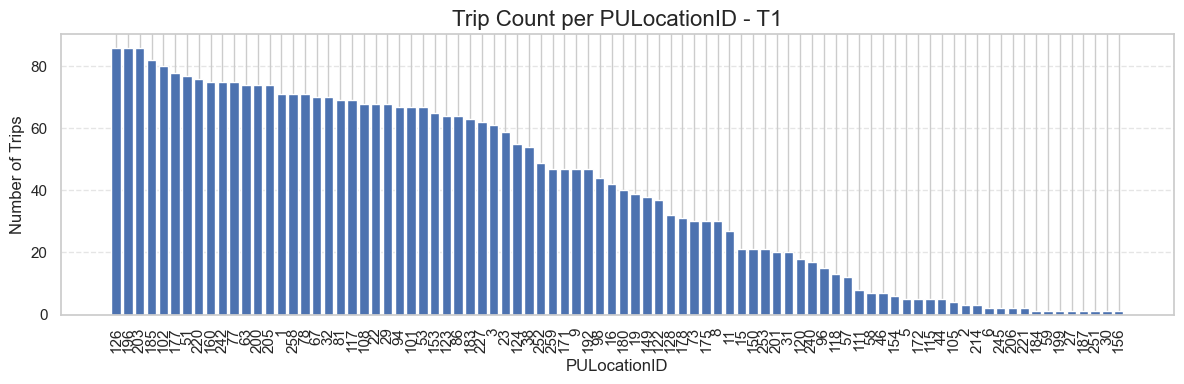

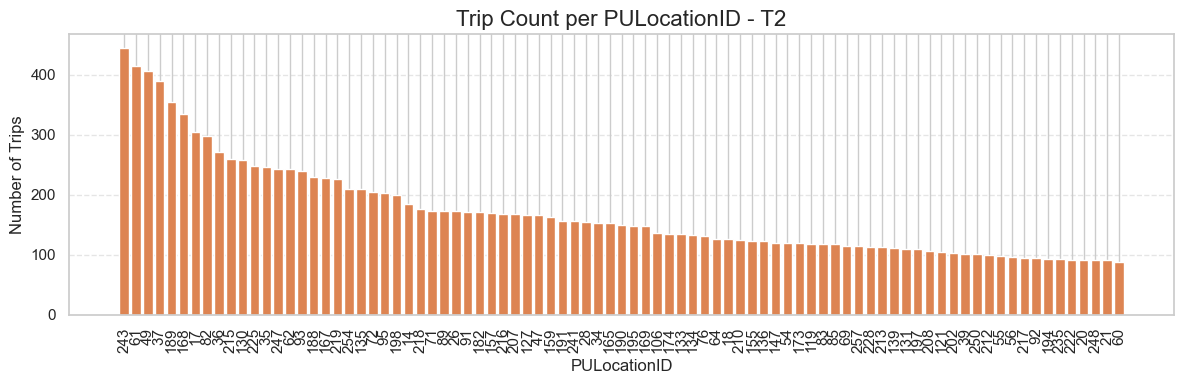

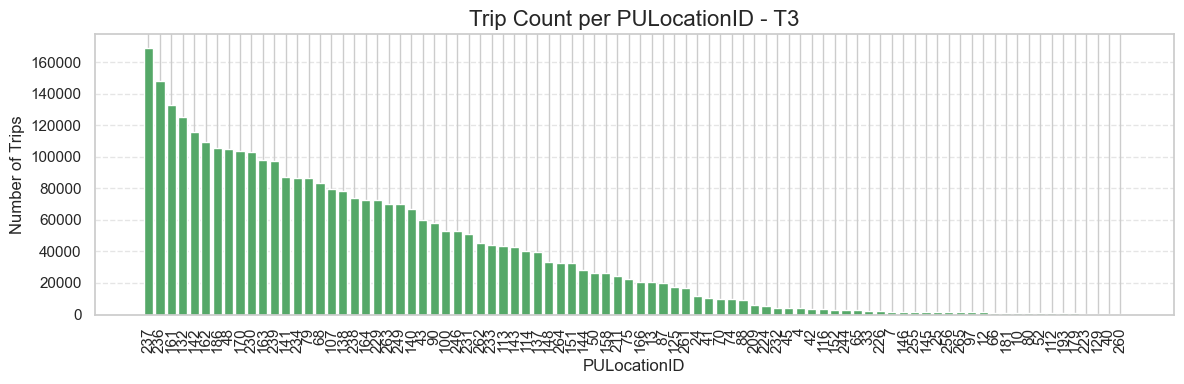

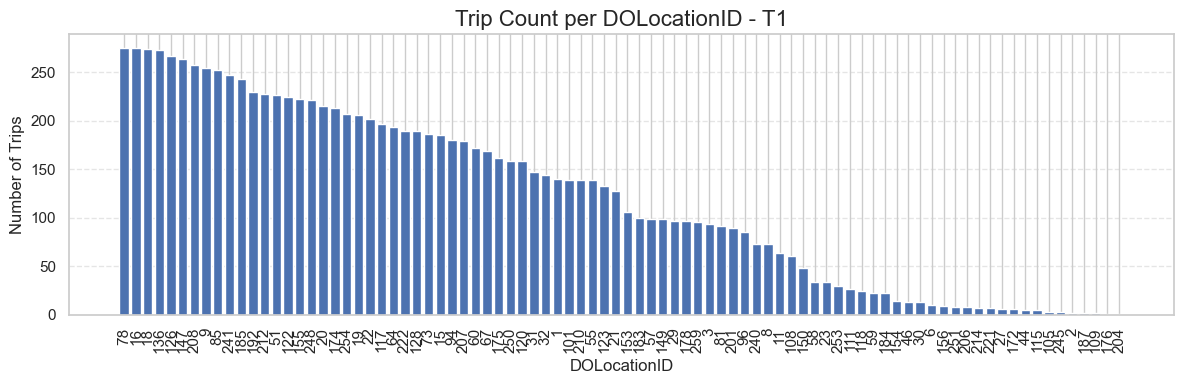

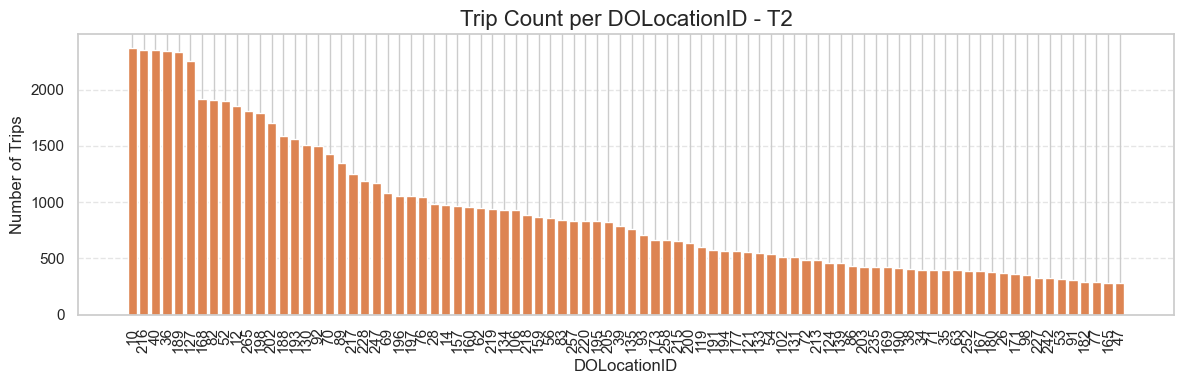

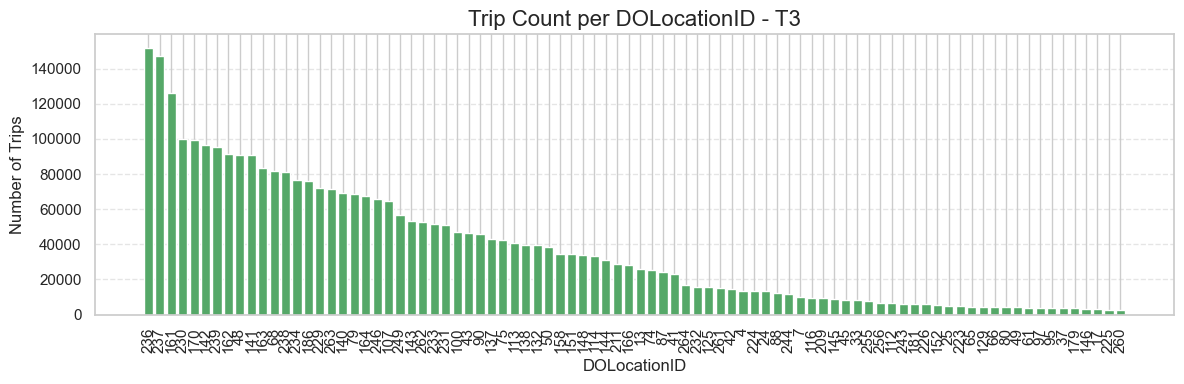

In [36]:
# Visualize as barplots by tertile
plot_trip_counts_by_tertile(divission_by_pickupID, ID_column="PULocationID")
plot_trip_counts_by_tertile(divission_by_dropoffID, ID_column="DOLocationID")

##### Updated Geospatial Map of Cleaned Zones
Finally, we visualize the tertile zones again to ensure geographic consistency and realistic representation of NYC activity in the final cleaned dataset.

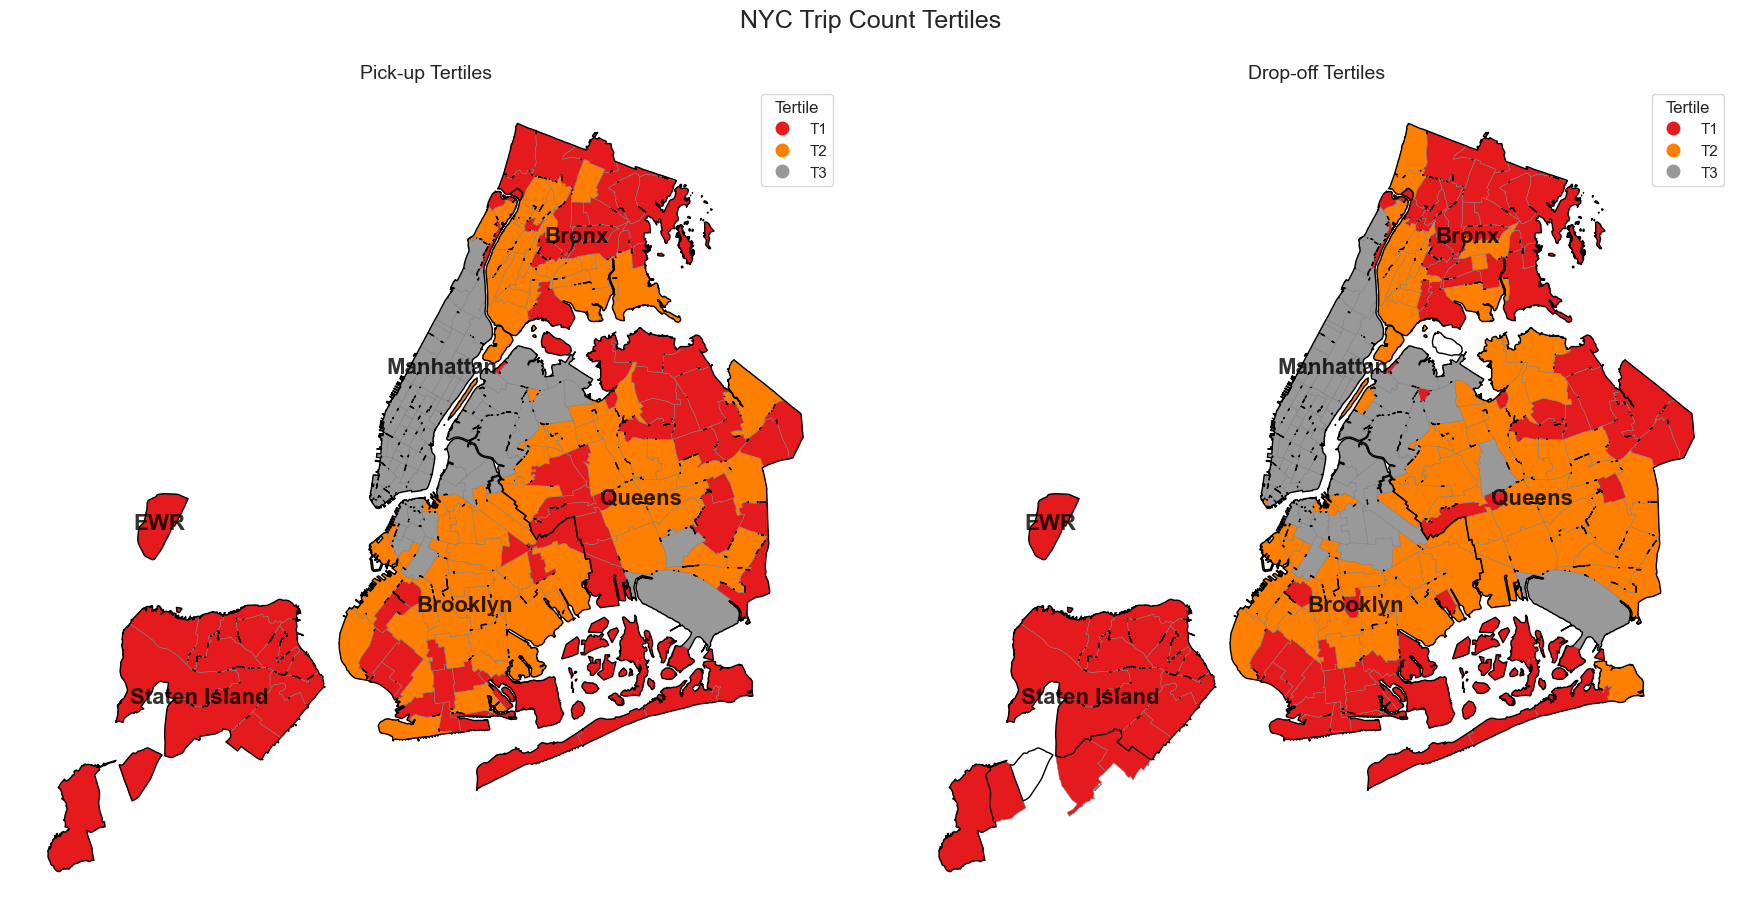

In [37]:
# Plot geospatial data with tertiles
plot_geospatial_data(zones_gdf, divission_by_pickupID, divission_by_dropoffID)

#### Feature Engineering
##### Feature–Target Relationships
To assess how features influence the prediction of fare_amount and trip_time_seconds, we use statistical and information-theoretic methods:

1. Mutual Information (MI)
We apply mutual_info_regression to measure the nonlinear dependency between each feature and the target variables. The top 10 features with the highest MI scores are visualized using barplots to understand which inputs most influence each target.

2. Correlation Analysis
In addition to MI, we explore linear and monotonic relationships using:

   - Pearson correlation — measures linear correlation.
   - Spearman correlation — captures monotonic relationships (increasing or decreasing).

These are visualized using a heatmap for direct comparison across the three metrics: MI, Pearson, and Spearman. This multi-faceted view helps:

- Identify strongly predictive features,
- Understand potential collinearity, and
- Confirm that non-linear associations (via MI) align with or differ from linear ones.

In [ ]:
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr, spearmanr

# Drop datetime columns from features
X = df_clean.drop(
    columns=[
        "fare_amount",
        "trip_time_seconds",
        "trip_duration",
        "tpep_pickup_datetime",
        "tpep_dropoff_datetime"
    ]
)

# Target 1: fare_amount
y_fare = df_clean["fare_amount"]
mi_fare = mutual_info_regression(X, y_fare, random_state=42)
mi_fare_df = pd.DataFrame({"Feature": X.columns, "MI Score": mi_fare}).sort_values(
    by="MI Score", ascending=False
)

# Target 2: trip_time_seconds
y_duration = df_clean["trip_time_seconds"]
mi_duration = mutual_info_regression(X, y_duration, random_state=42)
mi_duration_df = pd.DataFrame(
    {"Feature": X.columns, "MI Score": mi_duration}
).sort_values(by="MI Score", ascending=False)

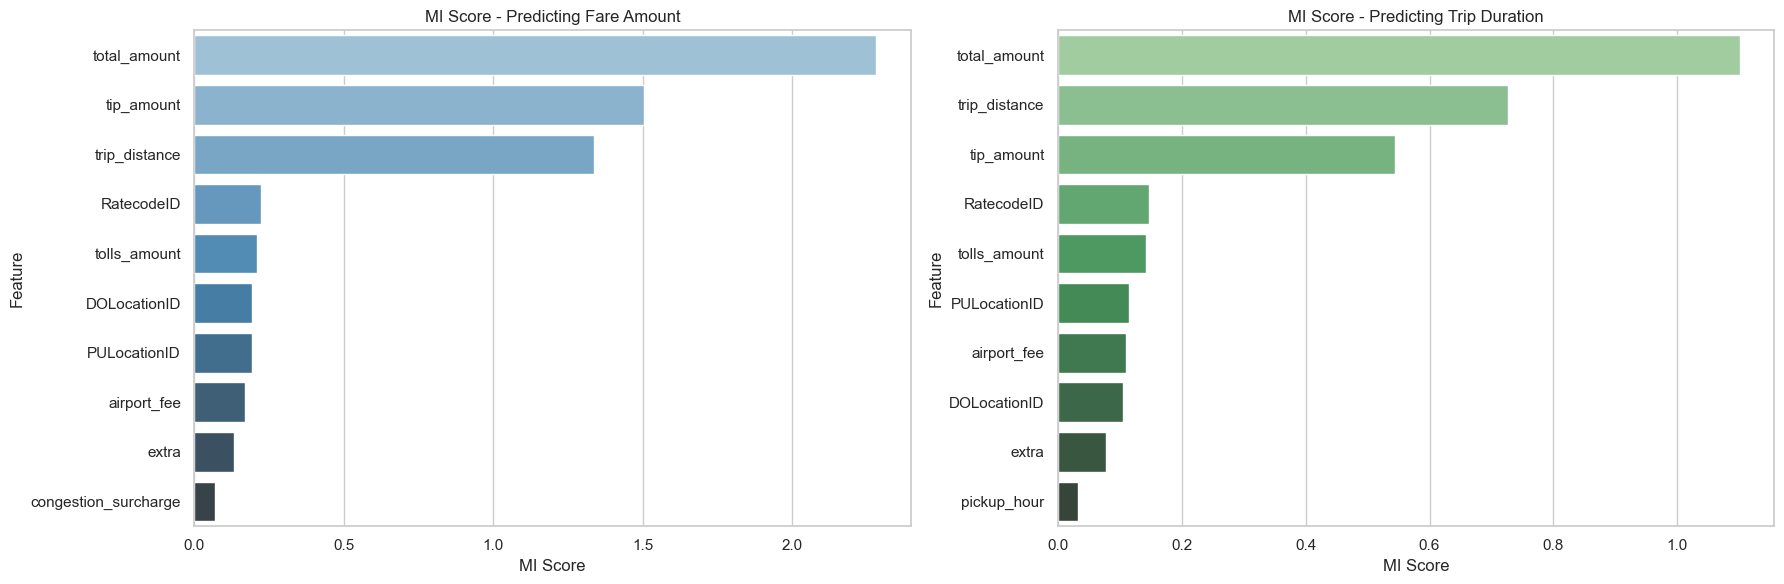

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(x="MI Score", y="Feature", hue="Feature", data=mi_fare_df.head(10), ax=axs[0], palette="Blues_d", legend=False)
axs[0].set_title("MI Score - Predicting Fare Amount")

sns.barplot( x="MI Score", y="Feature", hue="Feature", data=mi_duration_df.head(10), ax=axs[1], palette="Greens_d", legend=False)
axs[1].set_title("MI Score - Predicting Trip Duration")

plt.tight_layout()
plt.show()

The features shown above would be considered to train the model so that it appears before the trip, or it could be predicted. Those are: trip_distance, PULocationID, DOLocationID, and pickup_hour as the main. The airport_fee and congestion_surcharge features may also be considered if the model performs well with them, but they need to be predicted. 

Now, let's plot a heatmap to better see the MIC scores, as well as to the Pearson and Spearman scores.   

In [7]:
# Function to compute correlation metrics
def compute_correlation_metrics(X, y):
    results = []
    for col in X.columns:
        x_col = X[col].values
        mic = mutual_info_regression(X[[col]], y, discrete_features="auto")[0]
        pearson = pearsonr(x_col, y)[0]
        spearman = spearmanr(x_col, y)[0]
        results.append(
            {"Feature": col, "MIC": mic, "Pearson": pearson, "Spearman": spearman}
        )
    return pd.DataFrame(results).set_index("Feature")


# Compute correlation metrics
metrics_fare = compute_correlation_metrics(X, y_fare)
metrics_duration = compute_correlation_metrics(X, y_duration)

metrics_fare["Target"] = "fare_amount"
metrics_duration["Target"] = "trip_time_seconds"
df_metrics_combined = pd.concat([metrics_fare, metrics_duration])

# Prepare for display
df_metrics_combined.reset_index(inplace=True)
pivoted = df_metrics_combined.pivot(
    index="Feature", columns="Target", values=["MIC", "Pearson", "Spearman"]
)
pivoted.columns = ["_".join(col).strip() for col in pivoted.columns.values]
pivoted = pivoted.round(2)

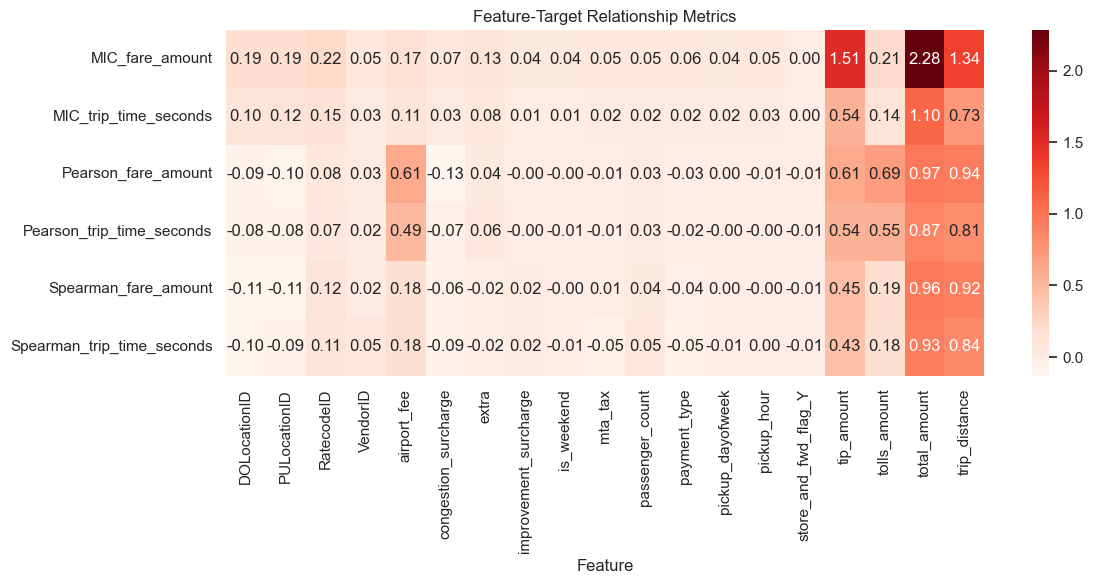

In [8]:
# Plot as heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivoted.T, annot=True, cmap="Reds", fmt=".2f", cbar=True)
plt.title("Feature-Target Relationship Metrics")
plt.tight_layout()
plt.show()

##### Adding Weather Condition
Sometimes, the weather condition can affect the flow of travel in vehicles such as taxi, therefore, we added the Weather feature, extracting the information about the hourly weather condition in NYC during May 2022 from the [Open Meteo API](https://open-meteo.com/en/docs/historical-weather-api?hourly=weather_code&start_date=2022-05-01&end_date=2022-06-01&temperature_unit=fahrenheit&wind_speed_unit=mph&timezone=America%2FNew_York#hourly_weather_variables) and relying on this [JSON of descriptions](https://gist.github.com/stellasphere/9490c195ed2b53c707087c8c2db4ec0c).

In [ ]:
import requests
from tqdm import tqdm
import geopandas as gpd
import json

# ---------------------------
# 1. Load weather descriptions (from Gist)
# ---------------------------
weather_desc_url = "https://gist.githubusercontent.com/stellasphere/9490c195ed2b53c707087c8c2db4ec0c/raw/descriptions.json"
weather_desc = requests.get(weather_desc_url).json()


def describe_weather(code, hour):
    """Return description for weather_code and hour (day/night)."""
    entry = weather_desc.get(str(int(code)))
    if not entry:
        return "Unknown"
    part = "night" if (hour < 6 or hour > 18) else "day"
    return entry.get(part, {}).get("description", "Unknown")


# ---------------------------
# 2. Load taxi zones and get lat/lon for each LocationID
# ---------------------------
zones_gdf = read_taxi_zones_dataset_from_shapefile()
zones_wgs84 = zones_gdf.to_crs(epsg=4326)  # Convert to lat/lon

# Compute centroids safely
zones_centroids = zones_gdf.to_crs(epsg=2263).centroid.to_crs(epsg=4326)
zones_wgs84["lat"] = zones_centroids.y
zones_wgs84["lon"] = zones_centroids.x

zone_coords = zones_wgs84[["LocationID", "lat", "lon"]].dropna()

# ---------------------------
# 3. Download weather for each LocationID
# ---------------------------
weather_data = []
print("Fetching weather using raw Open-Meteo API requests...")

for loc_id, row in tqdm(
    zone_coords.set_index("LocationID").iterrows(), total=len(zone_coords)
):
    lat, lon = row["lat"], row["lon"]

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": "2022-05-01",
        "end_date": "2022-06-01",
        "hourly": "weather_code",
        "timezone": "America/New_York",
    }

    try:
        r = requests.get(url, params=params, timeout=10)
        r.raise_for_status()
        data = r.json()

        times = pd.to_datetime(data["hourly"]["time"]).tz_localize("America/New_York")
        codes = data["hourly"]["weather_code"]

        df_hourly = pd.DataFrame(
            {"pickup_datetime": times, "weather_code": codes, "LocationID": loc_id}
        )
        df_hourly["hour"] = df_hourly["pickup_datetime"].dt.hour
        df_hourly["weather_desc"] = df_hourly.apply(
            lambda r: describe_weather(r.weather_code, r.hour), axis=1
        )
        weather_data.append(
            df_hourly[["pickup_datetime", "LocationID", "weather_desc"]]
        )

    except Exception as e:
        print(f"❌ Error at LocationID {loc_id}: {e}")
        continue

weather_df = pd.concat(weather_data, ignore_index=True)
print("✅ Finished fetching weather.")
print(f"✔️  Rows in weather_df: {len(weather_df):,}")
print(f"✔️  Unique datetimes: {weather_df['pickup_datetime'].nunique()}")
print(f"✔️  Unique LocationIDs: {weather_df['LocationID'].nunique()}")


# ---------------------------
# 4. Merge weather with trip data
# ---------------------------
# Round trip pickup times to the hour
df_raw["pickup_hour"] = df_raw["tpep_pickup_datetime"].dt.floor("h")
# Ensure both timestamps are timezone-aware
df_raw["pickup_hour"] = df_raw["pickup_hour"].dt.tz_localize("America/New_York")
weather_df["pickup_datetime"] = pd.to_datetime(
    weather_df["pickup_datetime"]
).dt.tz_convert("America/New_York")

# Merge on pickup hour and PULocationID
df_raw_weather = df_raw.merge(
    weather_df.drop_duplicates(subset=["pickup_datetime", "LocationID"]),
    left_on=["pickup_hour", "PULocationID"],
    right_on=["pickup_datetime", "LocationID"],
    how="left",
)

df_raw_weather.drop(columns=["pickup_datetime"], inplace=True)

# Optional: Check match quality
missing_ratio = df_raw_weather["weather_desc"].isna().mean()
print(f"\n🧪 Weather missing ratio: {missing_ratio:.2%}")
print(df_raw_weather["weather_desc"].value_counts().head())

Fetching weather using raw Open-Meteo API requests...


100%|██████████| 263/263 [03:59<00:00,  1.10it/s]


✅ Finished fetching weather.
✔️  Rows in weather_df: 201,984
✔️  Unique datetimes: 768
✔️  Unique LocationIDs: 260

🧪 Weather missing ratio: 1.35%
weather_desc
Cloudy           1697053
Sunny             368379
Light Drizzle     329502
Clear             256281
Partly Cloudy     237251
Name: count, dtype: int64


In [8]:
# Fill missing with most frequent weather per pickup_hour
most_common_weather = df_raw_weather.groupby("pickup_hour")["weather_desc"].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else "Unknown"
)
df_raw_weather["weather_desc"] = df_raw_weather.apply(
    lambda row: (
        most_common_weather.get(row["pickup_hour"], "Unknown")
        if pd.isna(row["weather_desc"])
        else row["weather_desc"]
    ),
    axis=1,
)
# Check if there are still missing values
missing_weather = df_raw_weather["weather_desc"].isna().sum()
print(f"Missing weather descriptions after filling: {missing_weather}")

Missing weather descriptions after filling: 0


In [ ]:
df_raw_weather.drop(columns=["pickup_hour", "LocationID"], inplace=True)
df_raw_weather.rename(columns={"weather_desc": "weather"}, inplace=True)

# Check for 'Unknown' weather descriptions
print("Rows with 'Unknown' weather description:", df_raw_weather[df_raw_weather["weather"] == "Unknown"].shape[0])
df_raw_weather = df_raw_weather[df_raw_weather["weather"] != "Unknown"]
df_raw_weather.reset_index(drop=True, inplace=True)

print("Rows after removing 'Unknown' weather description:", df_raw_weather.shape[0])
# Check unique weather descriptions
print()
print("Weather description counts after cleaning:") #, df_raw_weather["weather"].value_counts().head(10)
df_raw_weather["weather"].value_counts()

Rows with 'Unknown' weather description: 80
Rows after removing 'Unknown' weather description:3588174 

Weather description counts after cleaning:


weather
Cloudy           1654740
Sunny             359979
Light Drizzle     318944
Clear             247410
Partly Cloudy     231534
Mainly Sunny      158330
Drizzle           142876
Light Rain        122068
Mainly Clear      111423
Heavy Drizzle      49721
Rain               44780
Heavy Rain           338
Name: count, dtype: int64

It is possible that less frequent weather conditions are of little relevance to model training.

In order to train the model using the `congestion_surcharge` and `airport_fee` features, we clean and preprocess the df_raw_weather dataset again, but without modifying those features.

In [ ]:
df_raw_weather["congestion_surcharge"].value_counts()

congestion_surcharge
 2.50    3174639
 0.00     267504
-2.50      16485
 2.75         10
 0.75          9
-0.75          2
 1.00          1
Name: count, dtype: int64

In [30]:
df_raw_weather["airport_fee"].value_counts()

airport_fee
 0.00    3158971
 1.25     281309
-1.25       1863
Name: count, dtype: int64

**NOTE: In case we consider the `congestion_surcharge` and `airport_fee` features for model training, both will be converted to categorical type and applied One-hot Encoding. In addition, we will remove the unusual values of those features.**

In [ ]:
# Filter out trips with unusual congestion surcharge and airport fee values
df_raw_weather = df_raw_weather[df_raw_weather["congestion_surcharge"].isin([0.00, 2.50])]
df_raw_weather = df_raw_weather[df_raw_weather["airport_fee"].isin([0.0, 1.25])]

# Convert to string for consistency
df_raw_weather["congestion_surcharge"] = df_raw_weather["congestion_surcharge"].astype(str)
df_raw_weather["airport_fee"] = df_raw_weather["airport_fee"].astype(str)

# Save the final dataset with weather information
print("Final dataset shape with weather:", df_raw_weather.shape)

Final dataset shape with weather: (3440280, 20)


In [ ]:
# Save the final dataset
df_raw_weather.to_parquet("datasets/raw_data_with_weather.parquet", index=False)

# Run the pipeline on the raw weather data
df_cleaned_weather = run_pipeline_chunks(df_raw_weather)
# Save the cleaned data with weather information
df_cleaned_weather.to_parquet("datasets/cleaned_data_with_weather.parquet")

Processing data in chunks of size 50000...

[✓] Processed 3254302 rows successfully.
Final df_clean shape: (3254302, 25)


In [15]:
df_cleaned_weather[["fare_amount", "trip_time_seconds"]].describe()

fare_amount  trip_time_seconds
count  3.254302e+06       3.254302e+06
mean   1.341293e+01       9.159205e+02
std    1.049896e+01       7.018655e+02
min    2.000000e+00       3.100000e+01
25%    7.000000e+00       4.550000e+02
50%    1.000000e+01       7.340000e+02
75%    1.520000e+01       1.154000e+03
max    5.500000e+01       6.774000e+03

Let's see how well the dataset was cleaned up, through the fare vs duration plot.

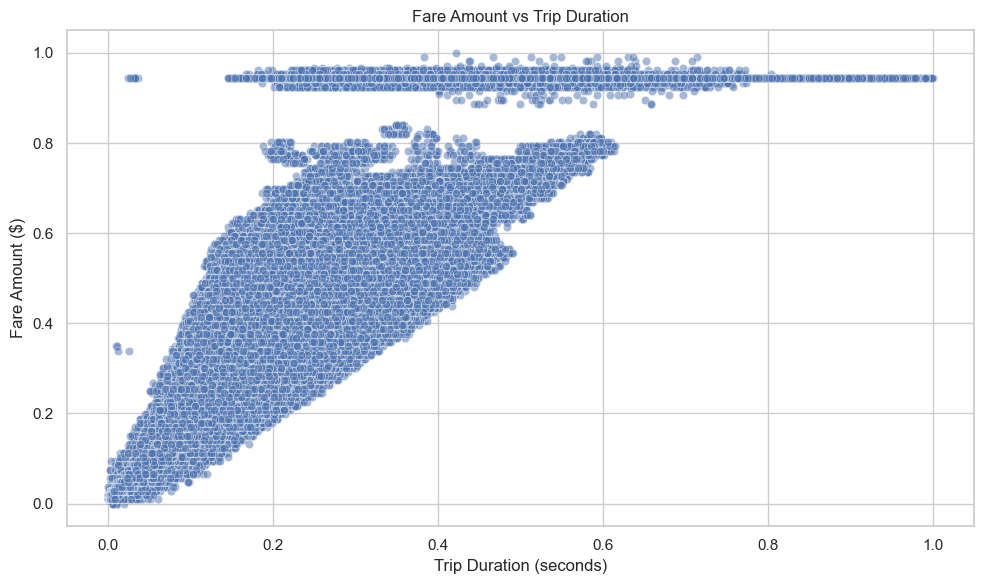

In [12]:
plot_fare_vs_duration(df_cleaned_weather)

#### Model Training and Evaluation
We train and compare multiple models using the prepared datasets (Before and after refilling):

Linear Regression: A simple baseline model to assess the linear relationships between features and the target.

XGBoost Regressor: A more powerful, tree-based ensemble method that handles nonlinear relationships, interactions, and missing values more effectively.

Both models are trained on the same feature set and evaluated to compare performance. This step helps establish a benchmark and informs future hyperparameter tuning or model selection.

To measure how much worse a model performs on the test set compared to the training set, the *percentage increase in error* will be computed: 
$$
\frac{\text{RMSE}_{\text{test}} - \text{RMSE}_{\text{train}}}{\text{RMSE}_{\text{train}}} \times 100
$$

#### Load and Splitting data
Here prepares the data for training a machine learning model. <br> Note that we apply a log-transformation (or the one specified) on the targets, as they seem to have a high variance.

In [31]:
df_clean = pd.read_parquet("datasets/cleaned_data_with_weather.parquet")
# Define feature and target columns
features = ["PULocationID", "DOLocationID", "pickup_hour", "trip_distance"]
targets = ["fare_amount", "trip_time_seconds"]
# Setup data for modeling
X_train, X_test, y_train, y_test = setup_data_for_modeling(df_clean, features, targets, tranf_method="log")

##### Base Model Training (Linear Regression)

In [4]:
base_model, _ = train_and_evaluate_model(X_train, X_test, y_train, y_test, model_type="Linear")


--- Fare Amount ($) ---
MAE:   0.2294
MedAE: 0.1996
RMSE:  0.2867
MSLE:  0.0070
R²:    0.7375
Explained Variance: 0.7375

--- Trip Duration (s) ---
MAE:   0.3996
MedAE: 0.3330
RMSE:  0.5097
MSLE:  0.0049
R²:    0.4749
Explained Variance: 0.4749


##### More-complex Model Trainig (XGBoost Regressor)
We first compare performance using two single-output models vs one multi-output model.


--- fare_amount ---
MAE:   0.0996
MedAE: 0.0773
RMSE:  0.1368
MSLE:  0.0017
R²:    0.9402
Explained Variance: 0.9402

--- trip_time_seconds ---
MAE:   0.2260
MedAE: 0.1814
RMSE:  0.2961
MSLE:  0.0017
R²:    0.8227
Explained Variance: 0.8227


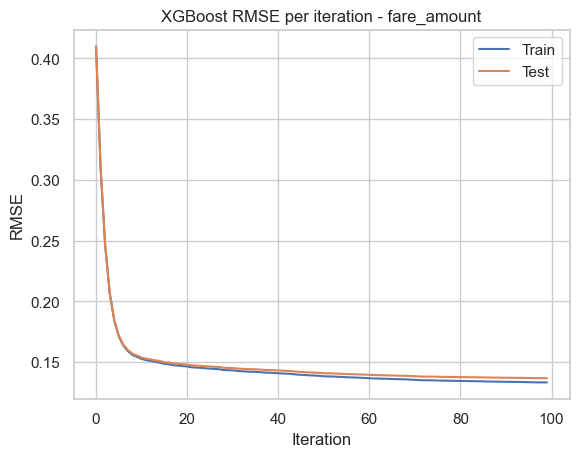

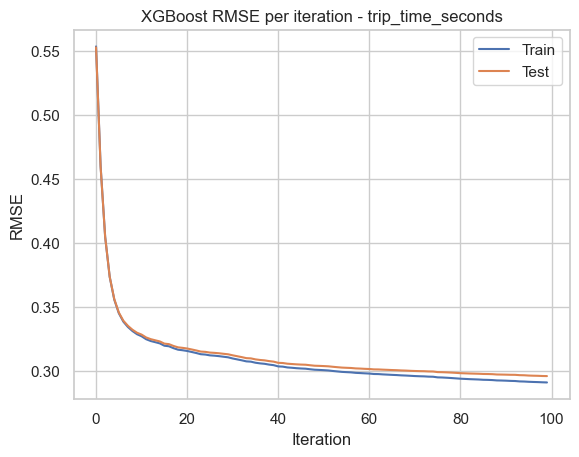

In [ ]:
from xgboost import XGBRegressor

from sklearn.metrics import (
    mean_absolute_error,
    root_mean_squared_error,
    median_absolute_error,
    mean_squared_log_error,
    r2_score,
    explained_variance_score,
)

# Function to evaluate a single model
def evaluate_model_single(y_true, y_pred, target_name="Target"):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    assert y_true.shape == y_pred.shape, "Shapes of y_true and y_pred must match"

    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    try:
        msle = mean_squared_log_error(y_true, y_pred)
    except ValueError:
        msle = np.nan

    residuals = y_true - y_pred

    print(f"\n--- {target_name} ---")
    print(f"MAE:   {mae:.4f}")
    print(f"MedAE: {medae:.4f}")
    print(f"RMSE:  {rmse:.4f}")
    print(f"MSLE:  {msle:.4f}")
    print(f"R²:    {r2:.4f}")
    print(f"Explained Variance: {evs:.4f}")

# Train one XGBRegressor per target and store evals_result
evals_result = {}

for target in targets:
    est = XGBRegressor(n_estimators=100,
            objective="reg:squarederror",
            random_state=42,
            enable_categorical=True, eval_metric="rmse")  # Pass eval_metric here
    est.fit(
        X_train,
        y_train[target],
        eval_set=[(X_train, y_train[target]), (X_test, y_test[target])],
        verbose=False,
    )
    
    # Predict on test set
    y_pred = est.predict(X_test)
    # Evaluate the model
    evaluate_model_single(y_test[target], y_pred, target)
    evals_result[target] = est.evals_result()

# Plot RMSE per iteration for each target
for target in targets:
    plt.figure()
    plt.plot(evals_result[target]["validation_0"]["rmse"], label="Train")
    plt.plot(evals_result[target]["validation_1"]["rmse"], label="Test")
    plt.title(f"XGBoost RMSE per iteration - {target}")
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

Now, we train a multioutput XGBoost model (with the MultiOutputRegressor class) using the same hyperparameters to compare.

In [22]:
xgb_model, y_pred = train_and_evaluate_model(X_train, X_test, y_train, y_test, model_type="XGB")


--- Fare Amount ($) ---
MAE:   0.0975
MedAE: 0.0754
RMSE:  0.1339
MSLE:  0.0016
R²:    0.9427
Explained Variance: 0.9427

--- Trip Duration (s) ---
MAE:   0.2221
MedAE: 0.1778
RMSE:  0.2914
MSLE:  0.0016
R²:    0.8283
Explained Variance: 0.8283


In [ ]:
# Report overfitting gap
pred_train = xgb_model.predict(X_train)
report_overfitting_gap(pred_train, y_pred, y_train, y_test)

Overfitting Report per Target:

Target: fare_amount
  RMSE (Train): 0.1290
  RMSE (Test):  0.1339
  Overfitting Rate: +3.83%

Target: trip_time_seconds
  RMSE (Train): 0.2838
  RMSE (Test):  0.2914
  Overfitting Rate: +2.68%



When comparing the metrics, it can be seen that the model performance improves using the MultiOutputRegressor class, so we will keep that line. But first, let's look at its performance visually and the importance of each variable in training the model.

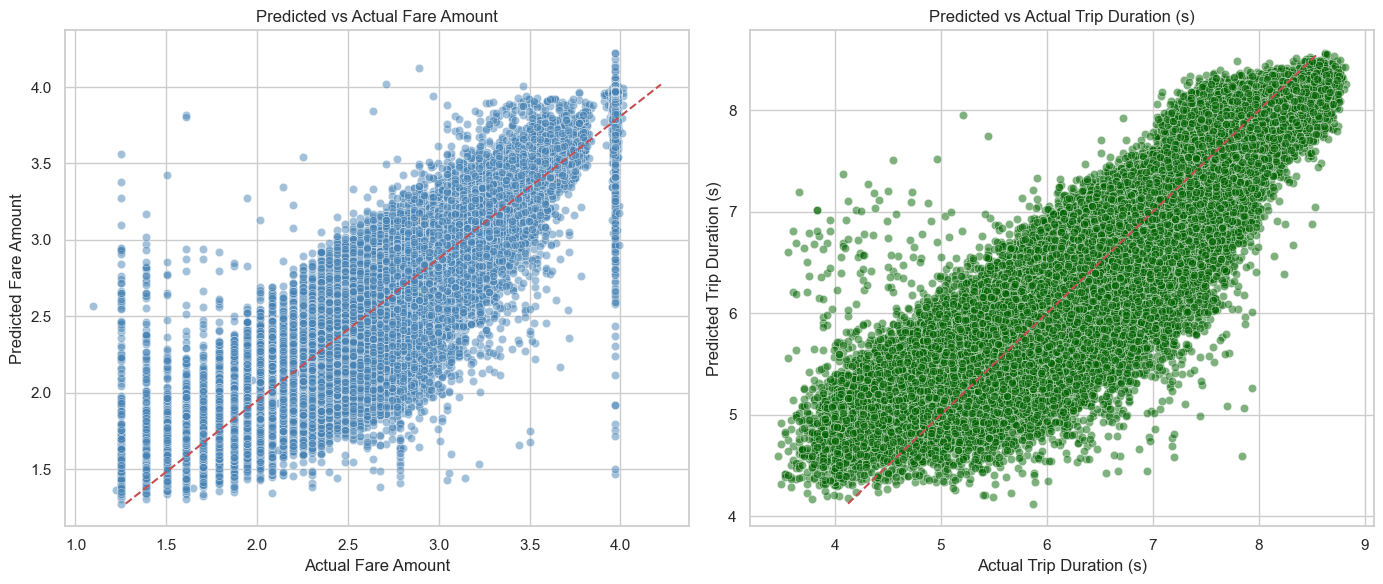

In [16]:
# Plot predictions vs actuals
plot_predictions_vs_actuals(y_pred, y_test)

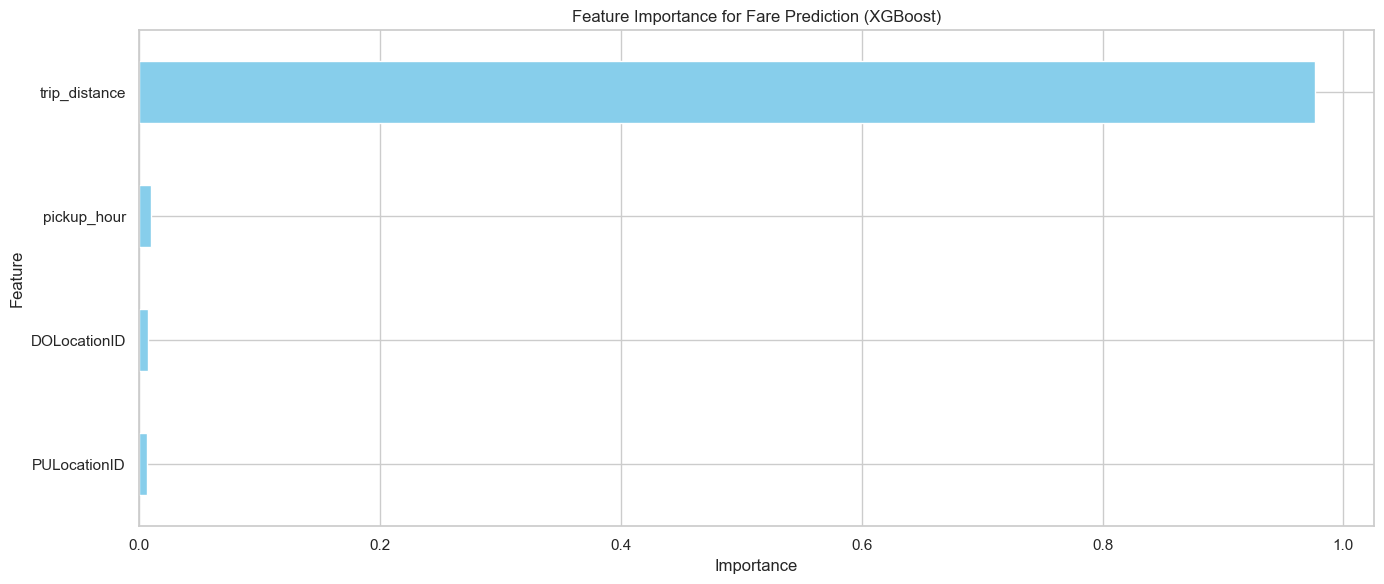

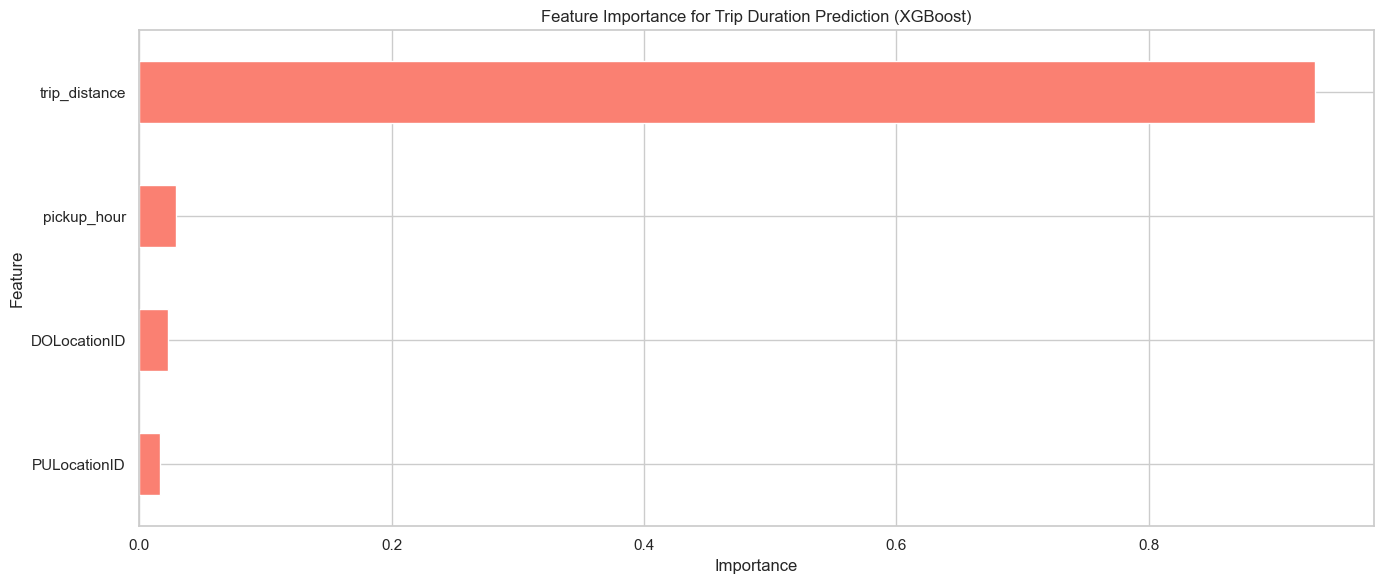

In [9]:
# Plot feature importances
plot_feature_importances(xgb_model, X_train)

In order to select the best model, we train and compare multiple tree-based models using the prepared dataset:

XGBoost Regressor: Trained and evaluated earlier. A robust gradient boosting algorithm that efficiently handles nonlinear relationships and interactions. Known for its accuracy and speed, especially on structured/tabular data.

LightGBM Regressor: A fast, leaf-wise gradient boosting model developed by Microsoft. It is optimized for high performance on large datasets and supports categorical features natively.

CatBoost Regressor: A gradient boosting model by Yandex designed to handle categorical features without explicit encoding. It performs well with minimal tuning and is particularly effective on datasets with many categorical variables.

##### LightGBM Regressor

In [14]:
lgb_model, pred_lgb = train_and_evaluate_model(X_train, X_test, y_train, y_test, model_type="LGBM")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 903
[LightGBM] [Info] Number of data points in the train set: 2603441, number of used features: 4
[LightGBM] [Info] Start training from score 2.488455
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 903
[LightGBM] [Info] Number of data points in the train set: 2603441, number of used features: 4
[LightGBM] [Info] Start training from score 6.580151

--- Fare Amount ($) ---
MAE:   0.1021
MedAE: 0.0799
RMSE:  0.1395
MSLE:  0.0018
R²:    0.9379
Explained Variance: 0.9379

--- Trip Duration (s) ---
MAE:   0.2303
MedAE: 0.1853
RMSE:  0.30

##### CatBoost Regressor

In [ ]:
cat_model, pred_cat = train_and_evaluate_model(X_train, X_test, y_train, y_test, model_type="CatBoost")


--- Fare Amount ($) ---
MAE:   0.1080
MedAE: 0.0858
RMSE:  0.1455
MSLE:  0.0019
R²:    0.9324
Explained Variance: 0.9324

--- Trip Duration (s) ---
MAE:   0.2438
MedAE: 0.1990
RMSE:  0.3151
MSLE:  0.0019
R²:    0.7993
Explained Variance: 0.7993


#### LeaderBoard and Comparison

In [12]:
# Load or reuse models (optional if already in memory)
models = {
    "XGBoost": xgb_model,
    "LightGBM": lgb_model,
    "CatBoost": cat_model,
}

# Inputs: Each model might have its own X_test/y_test due to log/expm1 use
X_tests = [X_test, X_test, X_test]
y_tests = [y_test, y_test, y_test]


# Evaluate leaderboard for all models
df_leaderboard = evaluate_models_leaderboard(
    models=models,
    X_tests=X_tests,
    y_tests=y_tests,
)

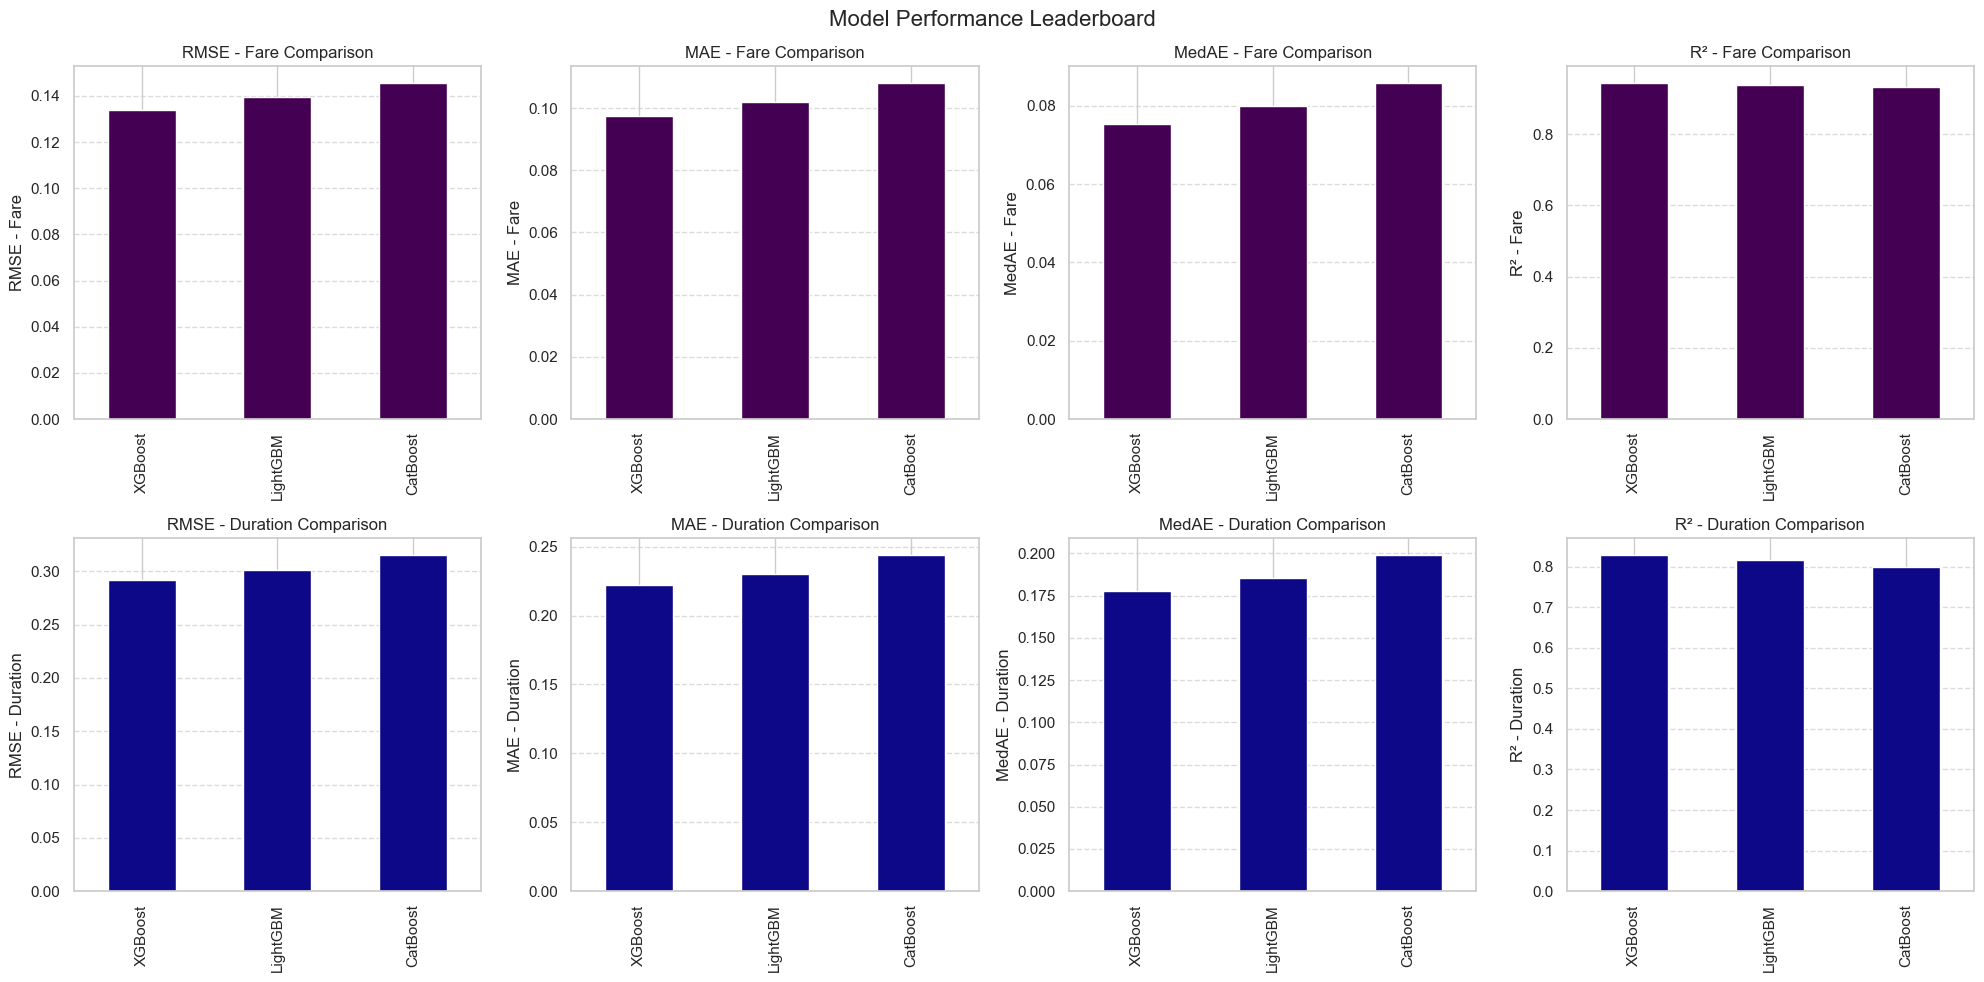

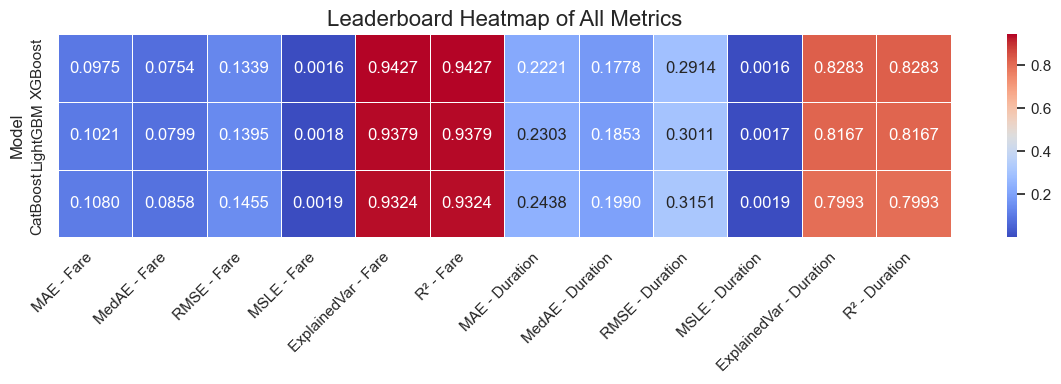

In [13]:
# Plot the leaderboard
plot_leaderboard(df_leaderboard)
plot_leaderboard_heatmap(df_leaderboard, normalize=False)

As you can see, the XGBoost model consistently outperformed the other ones, achieving the best balance between accuracy and generalization. Based on these results, we selected it as the final model for predicting our targets. 

Now, we have applied a log-trasform on targets so far. What about using another one, like Box-Cox and Yeo-Johnson? Let's do it.

##### Training using Box-Cox Transformation

In [33]:
# Setup data for modeling with Box-Cox transformation
X_train_bc, X_test_bc, y_train_bc, y_test_bc = setup_data_for_modeling(
    df_clean, features, targets, tranf_method="box-cox"
)

# Train and evaluate models on the new setup
xgb_model_bc, y_pred_bc = train_and_evaluate_model(X_train_bc, X_test_bc, y_train_bc, y_test_bc, model_type="XGB")


--- Fare Amount ($) ---
MAE:   0.0435
MedAE: 0.0317
RMSE:  0.0615
MSLE:  0.0007
R²:    0.9219
Explained Variance: 0.9219

--- Trip Duration (s) ---
MAE:   0.3404
MedAE: 0.2746
RMSE:  0.4441
MSLE:  0.0025
R²:    0.8322
Explained Variance: 0.8322


##### Training using Yeo-Johnson Transformation

In [34]:
# Setup data for modeling with Yeo-Johnson transformation
X_train_yj, X_test_yj, y_train_yj, y_test_yj = setup_data_for_modeling(df_clean, features, targets, tranf_method="yeo-johnson")

# Train and evaluate models on the new setup
xgb_model_yj, y_pred_yj = train_and_evaluate_model(X_train_yj, X_test_yj, y_train_yj, y_test_yj, model_type="XGB")


--- Fare Amount ($) ---
MAE:   0.0277
MedAE: 0.0203
RMSE:  0.0390
MSLE:  0.0003
R²:    0.9227
Explained Variance: 0.9227

--- Trip Duration (s) ---
MAE:   0.3361
MedAE: 0.2707
RMSE:  0.4383
MSLE:  0.0025
R²:    0.8321
Explained Variance: 0.8321


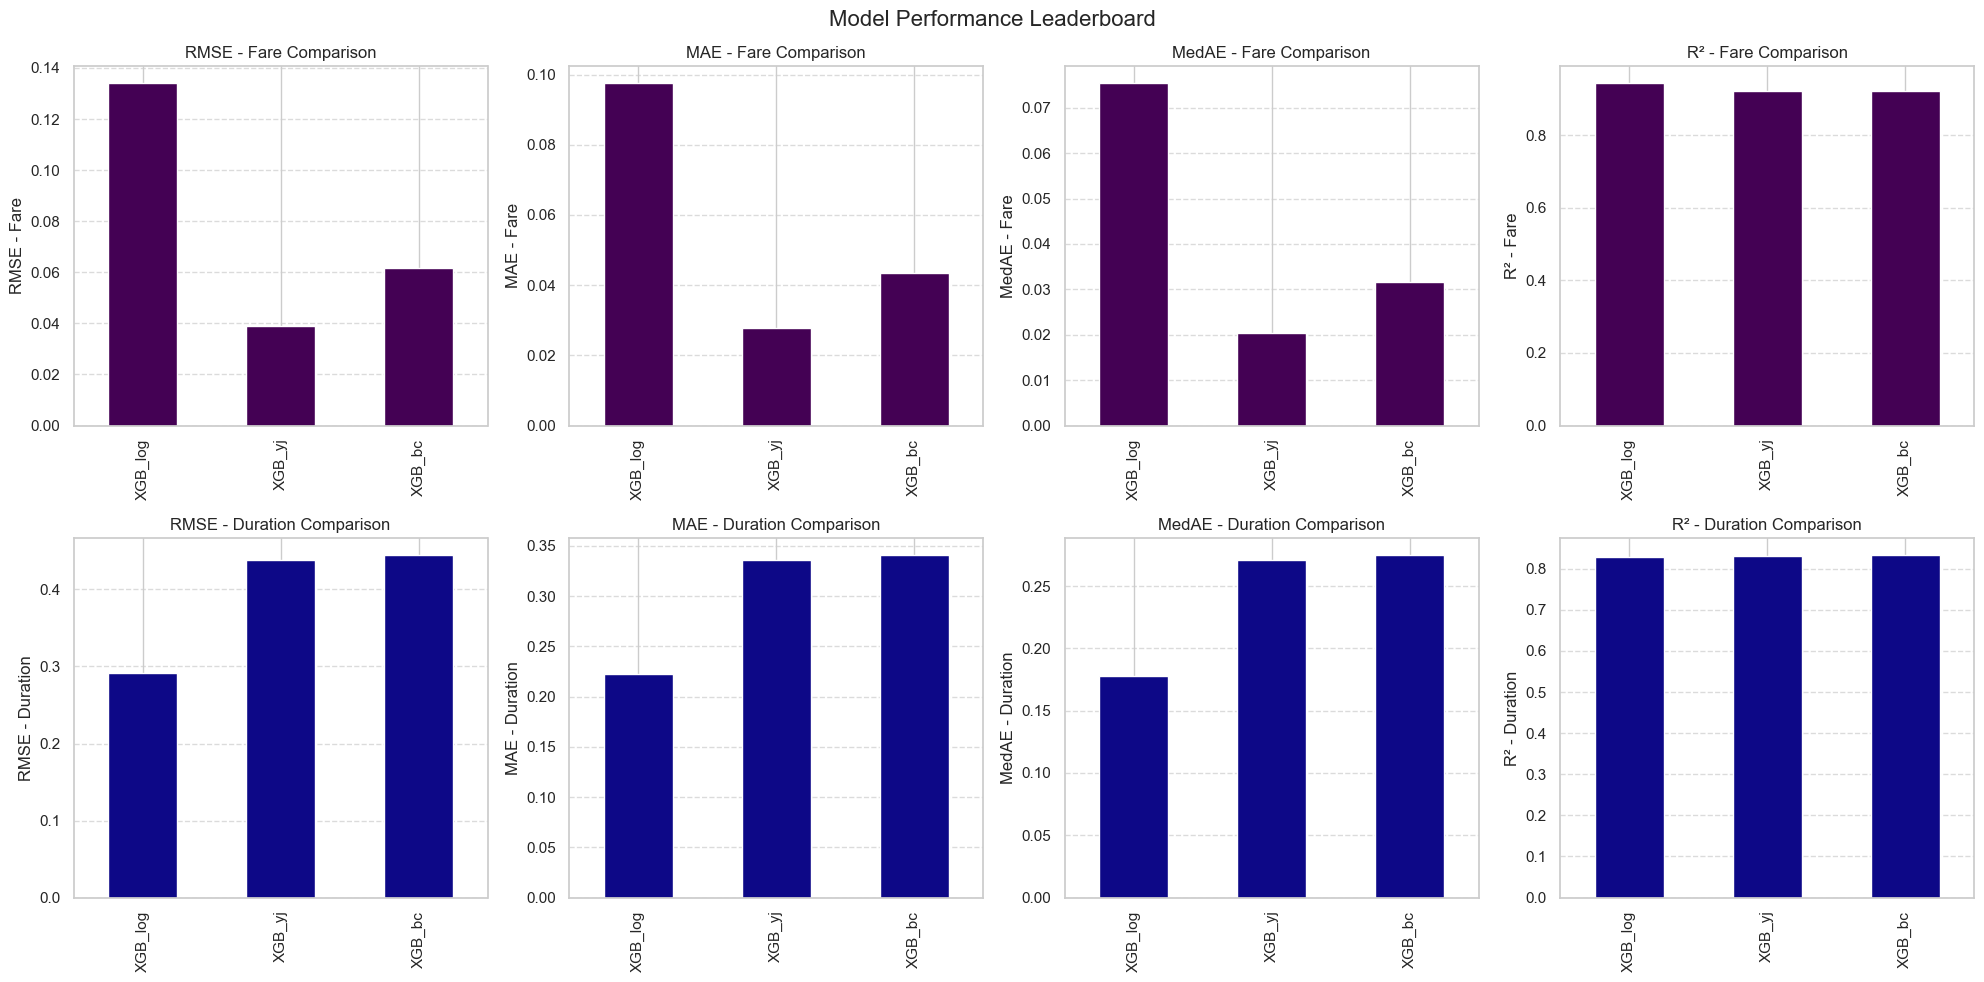

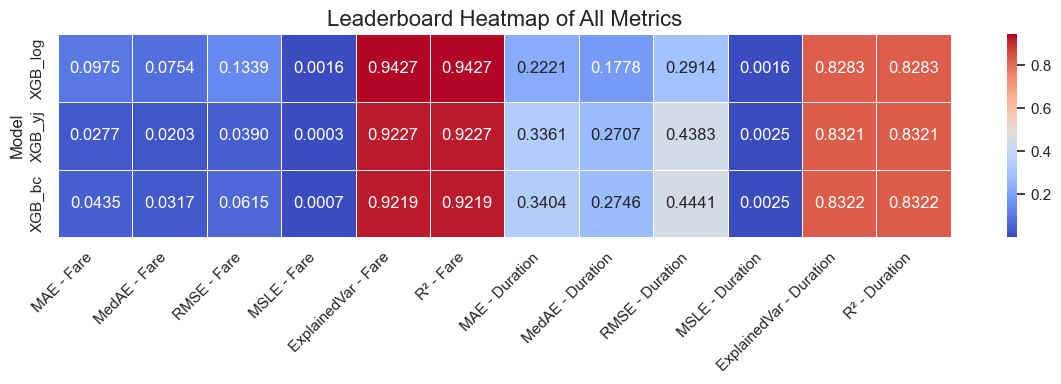

In [35]:
# Load or reuse models (optional if already in memory)
models = {
    "XGB_log": xgb_model,
    "XGB_bc": xgb_model_bc,
    "XGB_yj": xgb_model_yj,
}

# Inputs: Each model might have its own X_test/y_test due to log/expm1 use
X_tests = [X_test, X_test_bc, X_test_yj]
y_tests = [y_test, y_test_bc, y_test_yj]

# Evaluate leaderboard for all models
df_leaderboard = evaluate_models_leaderboard(models=models, X_tests=X_tests, y_tests=y_tests)

# Plot it
plot_leaderboard(df_leaderboard)
plot_leaderboard_heatmap(df_leaderboard, normalize=False)

The new transformations used seem to improve the fare_amount predictions, especially Yeo-Johnson, but worsen the losses over duration. Let's look at the overfitting. <br> This was the overfitting report by using log-transform.
```
Overfitting Report per Target:

Target: fare_amount
  RMSE (Train): 0.1290
  RMSE (Test):  0.1339
  Overfitting Rate: +3.83%

Target: trip_time_seconds
  RMSE (Train): 0.2838
  RMSE (Test):  0.2914
  Overfitting Rate: +2.68%
```

In [36]:
# Report overfitting gap
pred_train = xgb_model_bc.predict(X_train_bc)
report_overfitting_gap(pred_train, y_pred_bc, y_train_bc, y_test_bc)

Overfitting Report per Target:

Target: fare_amount
  RMSE (Train): 0.0593
  RMSE (Test):  0.0615
  Overfitting Rate: +3.68%

Target: trip_time_seconds
  RMSE (Train): 0.4324
  RMSE (Test):  0.4441
  Overfitting Rate: +2.72%



In [37]:
# Report overfitting gap
pred_train = xgb_model_yj.predict(X_train_yj)
report_overfitting_gap(pred_train, y_pred_yj, y_train_yj, y_test_yj)

Overfitting Report per Target:

Target: fare_amount
  RMSE (Train): 0.0377
  RMSE (Test):  0.0390
  Overfitting Rate: +3.50%

Target: trip_time_seconds
  RMSE (Train): 0.4267
  RMSE (Test):  0.4383
  Overfitting Rate: +2.71%



Again, the model performs better on the fare amount target using the other trasformations, but worse on the trip duration. Due to its low R² score and high losses,  the trip duration will be prioritized. Therefore, a log-transform benefits the model training more than the other ones, in this case.

So far, we have used just the resulted dataset after adding the weather labels. Remember that we have filled data with other month records, let's try with that.

##### Cleaned Refilled Data - Model Training

In [ ]:
df_clean_refilled = pd.read_parquet("datasets/refilled_trip_data_cleaned.parquet")
# Define feature and target columns
features = ["PULocationID", "DOLocationID", "pickup_hour", "trip_distance"]
targets = ["fare_amount", "trip_time_seconds"]
# Setup data for modeling
X_train, X_test, y_train, y_test = setup_data_for_modeling(
    df_clean_refilled, features, targets, tranf_method="log"
)

In [39]:
filled_model, y_pred = train_and_evaluate_model(X_train, X_test, y_train, y_test, model_type="XGB")


--- Fare Amount ($) ---
MAE:   0.0987
MedAE: 0.0759
RMSE:  0.1366
MSLE:  0.0017
R²:    0.9405
Explained Variance: 0.9405

--- Trip Duration (s) ---
MAE:   0.2219
MedAE: 0.1764
RMSE:  0.2936
MSLE:  0.0016
R²:    0.8253
Explained Variance: 0.8253


In [40]:
# Report overfitting gap
pred_train = filled_model.predict(X_train)
report_overfitting_gap(pred_train, y_pred, y_train, y_test)

Overfitting Report per Target:

Target: fare_amount
  RMSE (Train): 0.1305
  RMSE (Test):  0.1366
  Overfitting Rate: +4.70%

Target: trip_time_seconds
  RMSE (Train): 0.2841
  RMSE (Test):  0.2936
  Overfitting Rate: +3.36%



The model did not improve, so we will revert to the original cleaned data set.

To further improve prediction performance and reduce the diference between the features importance, we try adding more features such as weather, congestion_surcharge and airport_fee; however, the last two ones need to be predicted, so we will use the RegressorChain class to support that task. But first, let's just add the weather feature.

#### Training Using Weather feature

In [41]:
df_clean = pd.read_parquet("datasets/cleaned_data_with_weather.parquet")
# Define feature and target columns
features = [
    "PULocationID",
    "DOLocationID",
    "trip_distance",
    "pickup_hour",
    "weather"
]
# Define targets
targets = ["fare_amount", "trip_time_seconds"]

# Setup data for modeling
X_train_w, X_test_w, y_train_w, y_test_w = setup_data_for_modeling(
    df_clean, features, targets, tranf_method="log"
)

In [18]:
weather_model, y_pred_w = train_and_evaluate_model(X_train_w, X_test_w, y_train_w, y_test_w, model_type="XGB")

# Report overfitting gap
pred_train_w = weather_model.predict(X_train_w)
report_overfitting_gap(pred_train_w, y_pred_w, y_train_w, y_test_w)



--- Fare Amount ($) ---
MAE:   0.0929
MedAE: 0.0711
RMSE:  0.1285
MSLE:  0.0015
R²:    0.9473
Explained Variance: 0.9473

--- Trip Duration (s) ---
MAE:   0.2093
MedAE: 0.1661
RMSE:  0.2773
MSLE:  0.0015
R²:    0.8446
Explained Variance: 0.8446
Overfitting Report per Target:

Target: fare_amount
  RMSE (Train): 0.1236
  RMSE (Test):  0.1285
  Overfitting Rate: +3.97%

Target: trip_time_seconds
  RMSE (Train): 0.2696
  RMSE (Test):  0.2773
  Overfitting Rate: +2.84%



#### Train using more feature, supported by RegressorChain

The current model is best when using the weather feature, how about adding the other features mentioned?

In [ ]:
# Define feature and target columns
features = ["PULocationID", "DOLocationID", "trip_distance", "pickup_hour", "weather"]
targets = [
    "airport_fee_1.25",
    "congestion_surcharge_2.5",
    "fare_amount",
    "trip_time_seconds"
]
# Setup data for modeling
X_train_chain, X_test_chain, y_train_chain, y_test_chain = setup_data_for_modeling(
    df_clean, features, targets, tranf_method="log"
)

In [8]:
from sklearn.multioutput import RegressorChain
from xgboost import XGBRegressor

# Define the base XGBRegressor with the given parameters
base_model = XGBRegressor(
    n_estimators=300,
    objective="reg:squarederror",
    random_state=42,
    enable_categorical=True,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=1.0,
    reg_lambda=4.0,
    reg_alpha=2.0,
)
# Chain A: fare → duration
chain_a = RegressorChain(base_model, order=[0, 1, 2, 3])
chain_a.fit(X_train_chain, y_train_chain)
preds_a = chain_a.predict(X_test_chain)

# Chain B: duration → fare
chain_b = RegressorChain(base_model, order=[1, 0, 2, 3])
chain_b.fit(X_train_chain, y_train_chain)
preds_b = chain_b.predict(X_test_chain)

# Average predictions
final_pred = (preds_a + preds_b) / 2

In [9]:
# Evaluate the predictions
evaluate_model(y_test_chain, final_pred, targets)


--- airport_fee_1.25 ---
MAE:   0.0074
MedAE: 0.0002
RMSE:  0.0482
MSLE:  0.0014
R²:    0.9188
Explained Variance: 0.9188

--- congestion_surcharge_2.5 ---
MAE:   0.0162
MedAE: 0.0015
RMSE:  0.0603
MSLE:  0.0022
R²:    0.8438
Explained Variance: 0.8438

--- fare_amount ---
MAE:   0.1087
MedAE: 0.0824
RMSE:  0.1567
MSLE:  0.0023
R²:    0.9216
Explained Variance: 0.9238

--- trip_time_seconds ---
MAE:   0.2383
MedAE: 0.1853
RMSE:  0.3276
MSLE:  0.0021
R²:    0.7830
Explained Variance: 0.7831


Even if features like `congestion_surcharge` and `airport_fee` seemed useful, they may be leaked or delayed features, that's possible why the performance is worse using this strategy. Another features like `pickup_dayofweek` and `is_weekend` seem intuitively relevant, so that they capture latent traffic and behavioral patterns:

- Friday/Saturday: longer durations, night surcharges
- Weekends: fewer business trips, different locations

These could be more predictive, especially when combined with pickup_hour. So, let's try with them.

In [ ]:
# Define feature and target columns
features = [
    "PULocationID",
    "DOLocationID",
    "trip_distance",
    "pickup_hour",
    "is_weekend",
    "pickup_dayofweek",
    "weather"
]
# Define targets
targets = ["fare_amount", "trip_time_seconds"]

# Setup data for modeling
X_train_w, X_test_w, y_train_w, y_test_w = setup_data_for_modeling(
    df_clean, features, targets, tranf_method="log"
)

In [34]:
model_w, y_pred_w = train_and_evaluate_model(X_train_w, X_test_w, y_train_w, y_test_w, model_type="XGB")


--- Fare Amount ($) ---
MAE:   0.0859
MedAE: 0.0650
RMSE:  0.1202
MSLE:  0.0013
R²:    0.9539
Explained Variance: 0.9539

--- Trip Duration (s) ---
MAE:   0.1943
MedAE: 0.1524
RMSE:  0.2591
MSLE:  0.0013
R²:    0.8643
Explained Variance: 0.8643


The current model is the best so far. So now we can improve it some more by optimizing its hyperparameters. For reference, these are the hyperparameters used during this whole phase:
```
params = {"n_estimators": 100, "objective": "reg:squarederror", "random_state": 42, "enable_categorical": True}
```
#### Hyperparameterization

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

params = {
    "n_estimators": 200,
    "objective": "reg:squarederror",
    "random_state": 42,
    "enable_categorical": True,
    "max_depth": 12,
    "learning_rate": 0.1,
    "subsample": 0.9,  # Subsample ratio of the training instances
    "colsample_bytree": 0.85,  # Subsample ratio of columns per tree
    "reg_lambda": 4.0,  # L2 regularization term
    "reg_alpha": 3.6,  # L1 regularization term
}
model = MultiOutputRegressor(XGBRegressor(**params))
model.fit(X_train_w, y_train_w)
# Predict on test set
y_pred_w = model.predict(X_test_w)
evaluate_model(y_test_w, y_pred_w)


--- Fare Amount ($) ---
MAE:   0.0833
MedAE: 0.0631
RMSE:  0.1168
MSLE:  0.0012
R²:    0.9564
Explained Variance: 0.9564

--- Trip Duration (s) ---
MAE:   0.1869
MedAE: 0.1455
RMSE:  0.2503
MSLE:  0.0012
R²:    0.8733
Explained Variance: 0.8733


Overfitting Report per Target:

Target: fare_amount
  RMSE (Train): 0.1127
  RMSE (Test):  0.1168
  Overfitting Rate: +3.62%

Target: trip_time_seconds
  RMSE (Train): 0.2386
  RMSE (Test):  0.2503
  Overfitting Rate: +4.93%



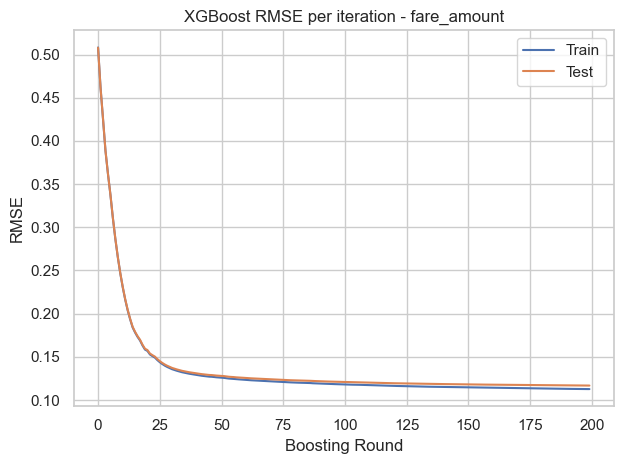

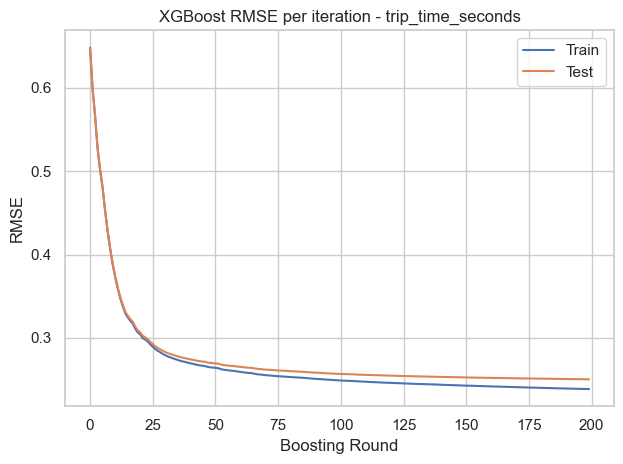

In [33]:
pred_train = model.predict(X_train_w)
# Report overfitting gap for the multi-output model
report_overfitting_gap(
    pred_train, y_pred_w, y_train_w, y_test_w, True, params, X_train_w, X_test_w,
)

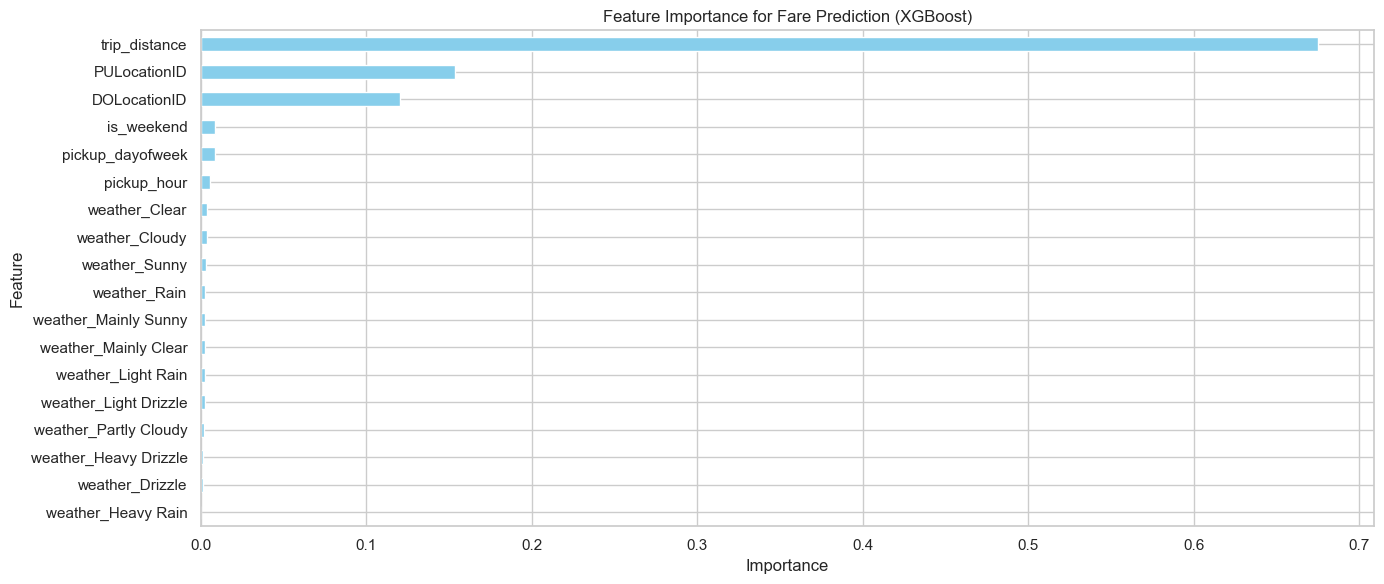

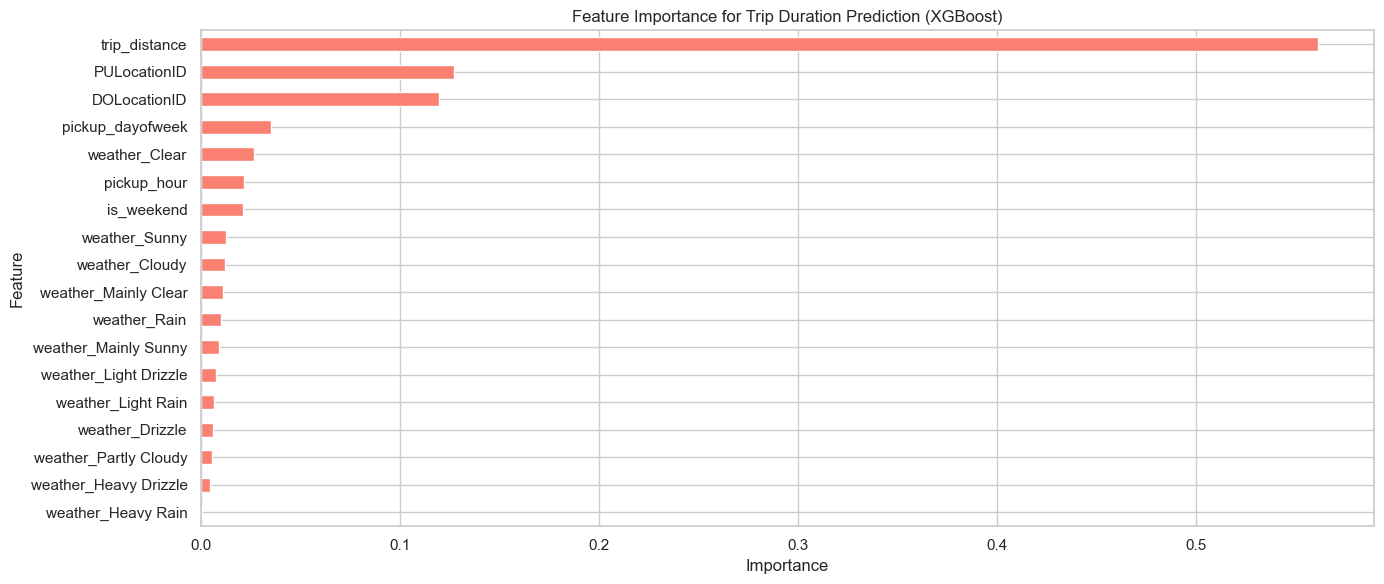

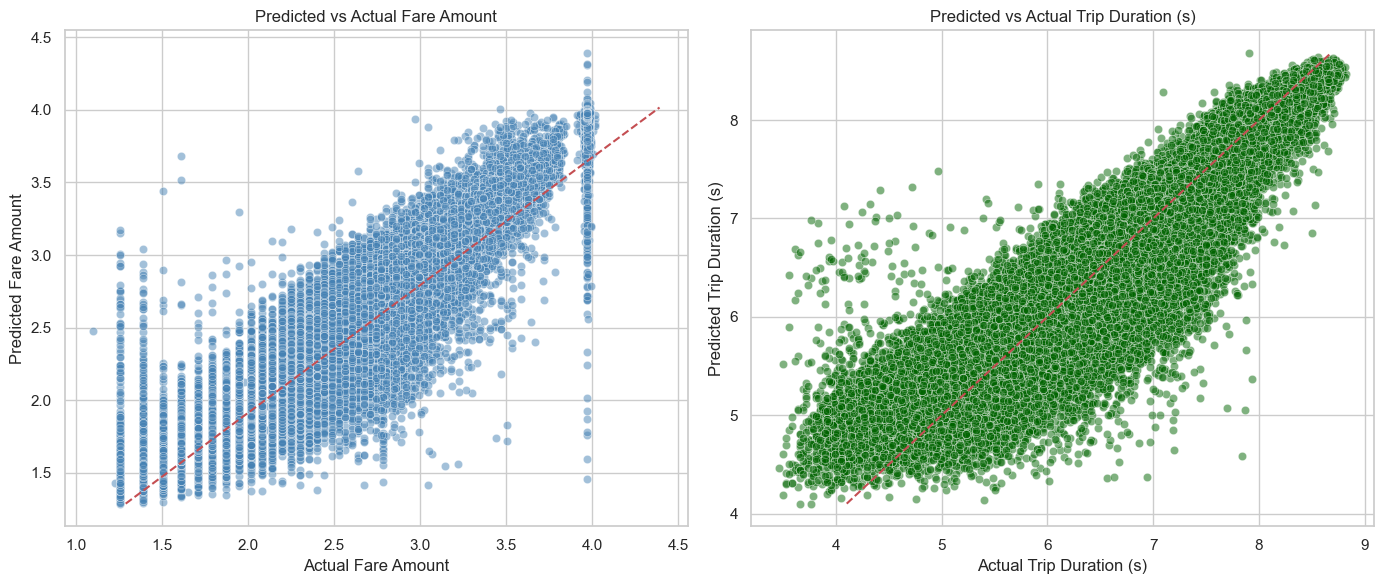

In [20]:
# Plot feature importances
plot_feature_importances(model, X_train_w)
# Plot predictions vs actuals
plot_predictions_vs_actuals(y_pred_w, y_test_w)

It's possible to have any problems with the OpenWeather API (to get the weather). <br> So, we retrain the model, removing that feature to avoid errors.

In [21]:
# Define feature and target columns
features = [
    "PULocationID",
    "DOLocationID",
    "trip_distance",
    "pickup_hour",
    "is_weekend",
    "pickup_dayofweek" # note that weather is not included here
]

# Setup data for modeling
X_train, X_test, y_train, y_test = setup_data_for_modeling(
    df_clean, features, targets, tranf_method="log"
)

In [ ]:
# Train the MultiOutputRegressor without weather
model_noweather = MultiOutputRegressor(XGBRegressor(**params))
model_noweather.fit(X_train, y_train)

# Predict on test set
y_pred = model_noweather.predict(X_test)
evaluate_model(y_test, y_pred)


--- Fare Amount ($) ---
MAE:   0.0840
MedAE: 0.0635
RMSE:  0.1181
MSLE:  0.0013
R²:    0.9555
Explained Variance: 0.9555

--- Trip Duration (s) ---
MAE:   0.1892
MedAE: 0.1476
RMSE:  0.2532
MSLE:  0.0012
R²:    0.8704
Explained Variance: 0.8704


In [24]:
pred_train = model_noweather.predict(X_train)
# Report overfitting gap for the multi-output model
report_overfitting_gap(pred_train, y_pred, y_train, y_test)

Overfitting Report per Target:

Target: fare_amount
  RMSE (Train): 0.1142
  RMSE (Test):  0.1181
  Overfitting Rate: +3.36%

Target: trip_time_seconds
  RMSE (Train): 0.2421
  RMSE (Test):  0.2532
  Overfitting Rate: +4.58%



Now, we finally can save the best model (both with and without weather).

In [24]:
joblib.dump(model, "model_weather.pkl", compress=3)

['model_weather.pkl']

In [25]:
joblib.dump(model_noweather, "trained_model.pkl", compress=3)

['trained_model.pkl']

Empirical testing showed that including `pickup_dayofweek` and `is_weekend` - together with weather labels - significantly improved model performance across multiple metrics (RMSE, R²), as well as feature importance. So even if there's no direct correlation between this set with the targets, the new features are stronger predictors when paired with time and zones features.

Although congestion_surcharge and airport_fee were initially considered due to their perceived relevance to pricing, they contributed little to the model based on mutual information scores and feature importance analysis. In contrast, day-of-week temporal features more effectively captured underlying traffic and trip behavior patterns, validating their inclusion in the final feature set.

#### Predictions
Finally, look at the predictions, through its real values (transformed back) and plot again those predictions vs the groung truth.  

In [40]:
fare_pred = y_pred_w[:, 0]  # fare_amount predictions
fare_pred = np.expm1(fare_pred).round(2)  # Round to 2 decimal places
print("Sample of fare predictions:", fare_pred[:10])  # Display first 10 predictions

duration_pred_secs = y_pred_w[:, 1]  # Assuming the second column is trip_duration in seconds
duration_pred_secs = np.expm1(duration_pred_secs).round(0)  # Round to nearest second
predicted_durations = pd.to_timedelta(duration_pred_secs, unit="s")
print("\nSample of trip duration predictions:")
predicted_durations[:10]

Sample of fare predictions: [23.14 22.77  8.27 10.94 31.84  8.2  12.57  5.44 14.41 13.39]

Sample of trip duration predictions:


TimedeltaIndex(['0 days 00:17:49', '0 days 00:13:45', '0 days 00:10:21',
                '0 days 00:14:11', '0 days 00:34:59', '0 days 00:10:17',
                '0 days 00:15:43', '0 days 00:05:13', '0 days 00:21:12',
                '0 days 00:17:46'],
               dtype='timedelta64[ns]', freq=None)

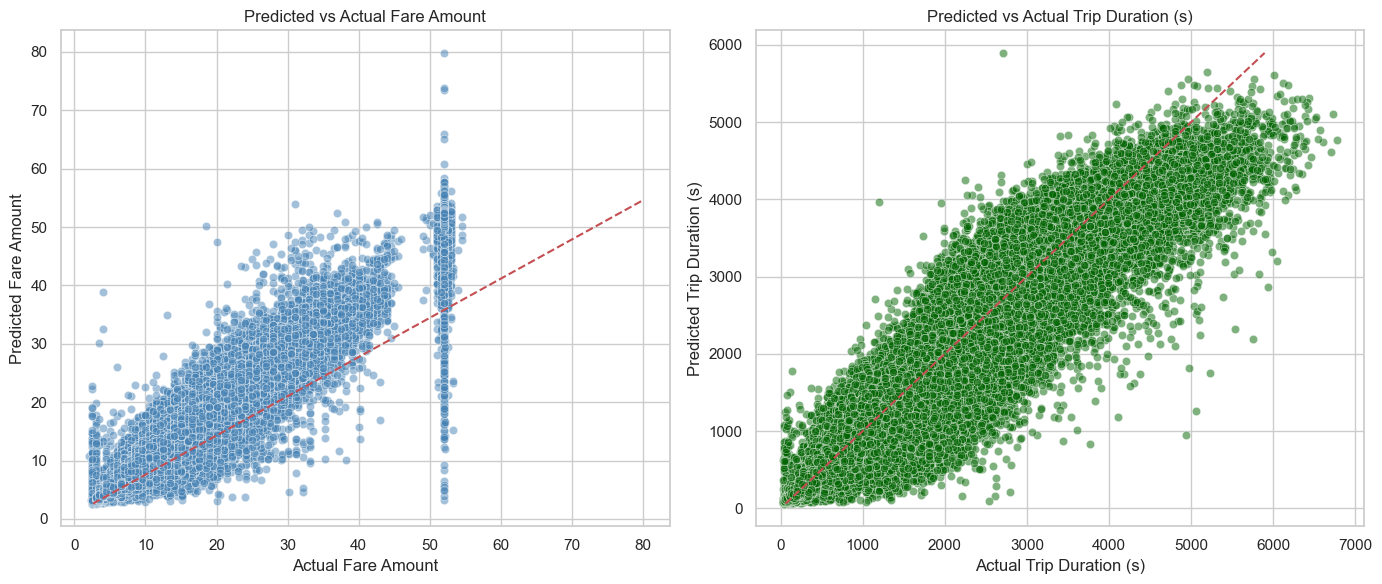

In [19]:
y_test_exp = np.expm1(y_test_w)
y_pred_exp = np.expm1(y_pred_w)
# Plot predictions vs actuals
plot_predictions_vs_actuals(y_pred_exp, y_test_exp)

#### Conclusion and Results
Throughout this analysis, we aimed to predict both the fare amount and the trip duration of NYC taxi rides using a variety of engineered features and advanced regression techniques. After evaluating several modeling strategies, we found that:

Feature selection played a key role in performance.
Although congestion_surcharge and airport_fee may intuitively seem relevant, models using them underperformed. Instead, temporal features like pickup_dayofweek and is_weekend significantly improved predictions, especially when predicting traffic-influenced targets such as trip duration.

Feature importance plots validated our intuition, with pickup_dayofweek, pickup_hour, and trip_distance among the top contributors.

Target transformation was essential.
Models trained without transforming the targets yielded considerably worse metrics. Applying a log transformation to fare_amount and trip_time_seconds stabilized variance, improved learning, and led to better generalization.

The final model, trained with the best hyperparameters using MultiOutputRegressor with an XGBoost base, achieved:

💰 Fare Amount RMSE (test): ~0.11 (after log transform)

⏱️ Trip Duration RMSE (test): ~0.25 (after log transform)

🔎 Low overfitting rates, indicating good generalization

📈 Feature importance supported domain expectations

These results confirm that thoughtful feature engineering, effective outlier handling, and appropriate target transformations are critical to achieving high-performing regression models in the taxi fare prediction context.